# NYC Taxi – Predykcja Czasu Przejazdu

## Cel biznesowy
Zbudowanie modelu predykcyjnego czasu przejazdu taksówką w Nowym Jorku, który umożliwi:
- Lepsze planowanie podróży dla pasażerów i kierowców
- Optymalizację tras i zarządzania flotą
- Skrócenie czasu oczekiwania i poprawę satysfakcji klientów

# 1. Import

In [150]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import scipy as sp
import scipy.stats as stats
from scipy.sparse import csr_matrix,hstack as sparse_hstack

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

import joblib

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# 2. Analiza jakości danych źródłowych

## 2.1 Przegląd wielkości i struktury plików

In [20]:
parquet_files = list(Path("data/raw").glob("*.parquet"))
print("Pliki Parquet:", parquet_files)

file_info = []
for file in parquet_files:
    try:
        size_mb = file.stat().st_size / (1024 * 1024)
        
        parquet_file = pq.ParquetFile(file)
        rows = parquet_file.metadata.num_rows
        cols = len(parquet_file.schema)
        
        file_info.append({
            'file': file.name,
            'size_mb': size_mb,
            'rows': rows,
            'columns': cols,
        })
        
        display(f"   {file.name}")
        display(f"     Rozmiar: {size_mb:.1f} MB")
        display(f"     Wiersze: {rows:,}")
        display(f"     Kolumny: {cols}")
        display()
        
    except Exception as e:
        print(f"Błąd: {file.name}: {e}")

total_rows = sum(file['rows'] for file in file_info)
total_size = sum(file['size_mb'] for file in file_info)
print("Podsumowanie:")
print(f"   Łączna liczba wierszy: {total_rows:,}")
print(f"   Łączny rozmiar plików: {total_size:.1f} MB")
print(f"   Średnia liczba wierszy na plik: {total_rows / len(file_info):,.0f}")

Pliki Parquet: [WindowsPath('data/raw/yellow_tripdata_2024-01.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-02.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-03.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-04.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-05.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-06.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-07.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-08.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-09.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-10.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-11.parquet'), WindowsPath('data/raw/yellow_tripdata_2024-12.parquet'), WindowsPath('data/raw/yellow_tripdata_2025-01.parquet'), WindowsPath('data/raw/yellow_tripdata_2025-02.parquet'), WindowsPath('data/raw/yellow_tripdata_2025-03.parquet')]


'   yellow_tripdata_2024-01.parquet'

'     Rozmiar: 47.6 MB'

'     Wiersze: 2,964,624'

'     Kolumny: 19'

'   yellow_tripdata_2024-02.parquet'

'     Rozmiar: 48.0 MB'

'     Wiersze: 3,007,526'

'     Kolumny: 19'

'   yellow_tripdata_2024-03.parquet'

'     Rozmiar: 57.3 MB'

'     Wiersze: 3,582,628'

'     Kolumny: 19'

'   yellow_tripdata_2024-04.parquet'

'     Rozmiar: 56.4 MB'

'     Wiersze: 3,514,289'

'     Kolumny: 19'

'   yellow_tripdata_2024-05.parquet'

'     Rozmiar: 59.7 MB'

'     Wiersze: 3,723,833'

'     Kolumny: 19'

'   yellow_tripdata_2024-06.parquet'

'     Rozmiar: 57.1 MB'

'     Wiersze: 3,539,193'

'     Kolumny: 19'

'   yellow_tripdata_2024-07.parquet'

'     Rozmiar: 49.9 MB'

'     Wiersze: 3,076,903'

'     Kolumny: 19'

'   yellow_tripdata_2024-08.parquet'

'     Rozmiar: 48.7 MB'

'     Wiersze: 2,979,183'

'     Kolumny: 19'

'   yellow_tripdata_2024-09.parquet'

'     Rozmiar: 58.3 MB'

'     Wiersze: 3,633,030'

'     Kolumny: 19'

'   yellow_tripdata_2024-10.parquet'

'     Rozmiar: 61.4 MB'

'     Wiersze: 3,833,771'

'     Kolumny: 19'

'   yellow_tripdata_2024-11.parquet'

'     Rozmiar: 57.8 MB'

'     Wiersze: 3,646,369'

'     Kolumny: 19'

'   yellow_tripdata_2024-12.parquet'

'     Rozmiar: 58.7 MB'

'     Wiersze: 3,668,371'

'     Kolumny: 19'

'   yellow_tripdata_2025-01.parquet'

'     Rozmiar: 56.4 MB'

'     Wiersze: 3,475,226'

'     Kolumny: 20'

'   yellow_tripdata_2025-02.parquet'

'     Rozmiar: 57.5 MB'

'     Wiersze: 3,577,543'

'     Kolumny: 20'

'   yellow_tripdata_2025-03.parquet'

'     Rozmiar: 66.7 MB'

'     Wiersze: 4,145,257'

'     Kolumny: 20'

Podsumowanie:
   Łączna liczba wierszy: 52,367,746
   Łączny rozmiar plików: 841.6 MB
   Średnia liczba wierszy na plik: 3,491,183


## 2.1 Schemt danych

In [21]:
sample = pd.read_parquet(parquet_files[0])

display(sample.info())
display(sample.describe())
print("Przykładowe dane z pierwszego pliku:")
display(sample.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

None

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.964624e+06,2964624,2964624,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06
mean,1.754204e+00,2024-01-17 00:46:36.431092,2024-01-17 01:02:13.208130,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2024-01-09 15:59:19.750000,2024-01-09 16:16:23,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:23:52.250000,2024-01-24 18:40:29,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00
std,4.325902e-01,NaN,NaN,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01


Przykładowe dane z pierwszego pliku:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


## 2.3 Analiza brakujących wartości

In [22]:
missing = []
for file in parquet_files:
    try:
        df = pd.read_parquet(file)
        na_ratio = df.isna().mean()
        missing.append(pd.DataFrame({
            'file': file.name,
            'column': na_ratio.index,
            'missing_ratio': na_ratio.values
        }))

    except Exception as e:
        print(f"Błąd podczas przetwarzania {file.name}: {e}")

missing_df = pd.concat(missing, ignore_index=True)
summary = missing_df.groupby('column')['missing_ratio'].agg(['mean','max','min']).sort_values(by='mean',ascending=False)
display(summary)

display(missing_df.pivot(index='column', columns='file', values='missing_ratio'))

,mean,max,min
column,,,
Airport_fee,0.118392,0.225556,0.047278
RatecodeID,0.118392,0.225556,0.047278
passenger_count,0.118392,0.225556,0.047278
congestion_surcharge,0.118392,0.225556,0.047278
store_and_fwd_flag,0.118392,0.225556,0.047278
DOLocationID,0.000000,0.000000,0.000000
PULocationID,0.000000,0.000000,0.000000
cbd_congestion_fee,0.000000,0.000000,0.000000
extra,0.000000,0.000000,0.000000


file,yellow_tripdata_2024-01.parquet,yellow_tripdata_2024-02.parquet,yellow_tripdata_2024-03.parquet,yellow_tripdata_2024-04.parquet,yellow_tripdata_2024-05.parquet,yellow_tripdata_2024-06.parquet,yellow_tripdata_2024-07.parquet,yellow_tripdata_2024-08.parquet,yellow_tripdata_2024-09.parquet,yellow_tripdata_2024-10.parquet,yellow_tripdata_2024-11.parquet,yellow_tripdata_2024-12.parquet,yellow_tripdata_2025-01.parquet,yellow_tripdata_2025-02.parquet,yellow_tripdata_2025-03.parquet
column,,,,,,,,,,,,,,,
Airport_fee,0.047278,0.061715,0.11896,0.116261,0.108669,0.116066,0.090672,0.086825,0.133148,0.102743,0.102478,0.088947,0.155428,0.225556,0.221135
DOLocationID,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PULocationID,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RatecodeID,0.047278,0.061715,0.11896,0.116261,0.108669,0.116066,0.090672,0.086825,0.133148,0.102743,0.102478,0.088947,0.155428,0.225556,0.221135
VendorID,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cbd_congestion_fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
congestion_surcharge,0.047278,0.061715,0.11896,0.116261,0.108669,0.116066,0.090672,0.086825,0.133148,0.102743,0.102478,0.088947,0.155428,0.225556,0.221135
extra,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fare_amount,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
cols = ['Airport_fee','RatecodeID','passenger_count','congestion_surcharge','store_and_fwd_flag']
for file in parquet_files:
    try:
        df = pd.read_parquet(file)
        display(f"Liczba wierszy zawierających null w każdej z kolumn: {df[cols].isna().all(axis=1).sum()}")
        display(f"Liczba maksymalnej liczby nulli kolumnie: {df.isna().sum().max()}")
    except Exception as e:
        print(f"Błąd podczas przetwarzania {file.name}: {e}")

'Liczba wierszy zawierających null w każdej z kolumn: 140162'

'Liczba maksymalnej liczby nulli kolumnie: 140162'

'Liczba wierszy zawierających null w każdej z kolumn: 185610'

'Liczba maksymalnej liczby nulli kolumnie: 185610'

'Liczba wierszy zawierających null w każdej z kolumn: 426190'

'Liczba maksymalnej liczby nulli kolumnie: 426190'

'Liczba wierszy zawierających null w każdej z kolumn: 408576'

'Liczba maksymalnej liczby nulli kolumnie: 408576'

'Liczba wierszy zawierających null w każdej z kolumn: 404666'

'Liczba maksymalnej liczby nulli kolumnie: 404666'

'Liczba wierszy zawierających null w każdej z kolumn: 410781'

'Liczba maksymalnej liczby nulli kolumnie: 410781'

'Liczba wierszy zawierających null w każdej z kolumn: 278989'

'Liczba maksymalnej liczby nulli kolumnie: 278989'

'Liczba wierszy zawierających null w każdej z kolumn: 258667'

'Liczba maksymalnej liczby nulli kolumnie: 258667'

'Liczba wierszy zawierających null w każdej z kolumn: 483731'

'Liczba maksymalnej liczby nulli kolumnie: 483731'

'Liczba wierszy zawierających null w każdej z kolumn: 393895'

'Liczba maksymalnej liczby nulli kolumnie: 393895'

'Liczba wierszy zawierających null w każdej z kolumn: 373674'

'Liczba maksymalnej liczby nulli kolumnie: 373674'

'Liczba wierszy zawierających null w każdej z kolumn: 326291'

'Liczba maksymalnej liczby nulli kolumnie: 326291'

'Liczba wierszy zawierających null w każdej z kolumn: 540149'

'Liczba maksymalnej liczby nulli kolumnie: 540149'

'Liczba wierszy zawierających null w każdej z kolumn: 806937'

'Liczba maksymalnej liczby nulli kolumnie: 806937'

'Liczba wierszy zawierających null w każdej z kolumn: 916663'

'Liczba maksymalnej liczby nulli kolumnie: 916663'

In [24]:
df[df['passenger_count'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
3228594,2,2025-03-01 00:38:00,2025-03-01 00:47:00,NaN,1.69,NaN,None,68,249,0,-4.75,0.0,0.5,0.0,0.0,1.0,4.76,NaN,NaN,0.75
3228595,2,2025-03-01 00:12:10,2025-03-01 00:12:27,NaN,0.02,NaN,None,152,152,0,17.45,0.0,0.5,0.0,0.0,1.0,18.95,NaN,NaN,0.00
3228596,2,2025-03-01 00:27:50,2025-03-01 00:35:59,NaN,1.62,NaN,None,42,41,0,-1.50,0.0,0.5,0.0,0.0,1.0,2.00,NaN,NaN,0.00
3228597,2,2025-03-01 00:48:18,2025-03-01 01:14:38,NaN,8.67,NaN,None,24,88,0,38.65,0.0,0.5,0.0,0.0,1.0,43.40,NaN,NaN,0.75
3228598,2,2025-03-01 00:42:34,2025-03-01 01:15:33,NaN,4.24,NaN,None,163,87,0,34.48,0.0,0.5,0.0,0.0,1.0,39.23,NaN,NaN,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4145252,2,2025-03-31 23:10:10,2025-03-31 23:42:49,NaN,10.04,NaN,None,177,205,0,45.98,0.0,0.5,0.0,0.0,1.0,47.48,NaN,NaN,0.00
4145253,2,2025-03-31 23:14:47,2025-03-31 23:32:05,NaN,3.01,NaN,None,186,140,0,21.70,0.0,0.5,0.0,0.0,1.0,26.45,NaN,NaN,0.75
4145254,2,2025-03-31 23:18:16,2025-03-31 23:40:15,NaN,7.44,NaN,None,48,243,0,31.97,0.0,0.5,0.0,0.0,1.0,36.72,NaN,NaN,0.75
4145255,2,2025-03-31 23:30:16,2025-03-31 23:52:23,NaN,4.99,NaN,None,68,262,0,-4.75,0.0,0.5,0.0,0.0,1.0,6.14,NaN,NaN,0.75


W każdym pliku brakujące dane w analizowanych kolumnach (`Airport_fee`, `RatecodeID`, `passenger_count`, `congestion_surcharge`, `store_and_fwd_flag`) występują zawsze w tych samych wierszach. 
- **Uwaga**: Te kolumny nie zostaną uwzględnione w dalszej analizie, ponieważ nie są znane w momencie estymacji czasu przejazdu (czyli gdy model ma przewidzieć czas przed rozpoczęciem podróży).

## 2.4 Analiza duplikatów

In [25]:
duplicates = []
for file in parquet_files:
    try:
        df = pd.read_parquet(file)
        dup_ratio = df.duplicated().mean()
        dup_count = df.duplicated().sum()
        duplicates.append({
            'file': file.name,
            'duplicate_ratio': dup_ratio,
            'duplicate_count': dup_count
        })
        print(f"{file.name} - Procent duplikatów w pliku : {dup_ratio:.2%}, Liczba duplikatów: {dup_count}")      
    except Exception as e:
        print(f"Błąd podczas przetwarzania {file.name}: {e}")

yellow_tripdata_2024-01.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0
yellow_tripdata_2024-02.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 1
yellow_tripdata_2024-03.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0
yellow_tripdata_2024-04.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0
yellow_tripdata_2024-05.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0
yellow_tripdata_2024-06.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0
yellow_tripdata_2024-07.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 1
yellow_tripdata_2024-08.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0
yellow_tripdata_2024-09.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0
yellow_tripdata_2024-10.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 2
yellow_tripdata_2024-11.parquet - Procent duplikatów w pliku : 0.00%, Liczba duplikatów: 0

Liczba duplikatów jest znikoma

## 2.5 Indentyfikacja błędów logicznych

In [26]:
for file in parquet_files:
    try:
        df = pd.read_parquet(file)
        df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
        
        negative_duration_count = (df['trip_duration'] <= 0).sum()
        negative_distance_count = (df['trip_distance'] <= 0).sum()

        display(f"{file.name}")
        display(f"  Czas przejazdu <= 0 min: {negative_duration_count}")
        display(f"  Dystans <= 0 mil: {negative_distance_count}")
       
    except Exception as e:
        print(f"Błąd podczas przetwarzania {file.name}: {e}")

'yellow_tripdata_2024-01.parquet'

'  Czas przejazdu <= 0 min: 870'

'  Dystans <= 0 mil: 60371'

'yellow_tripdata_2024-02.parquet'

'  Czas przejazdu <= 0 min: 803'

'  Dystans <= 0 mil: 68225'

'yellow_tripdata_2024-03.parquet'

'  Czas przejazdu <= 0 min: 1128'

'  Dystans <= 0 mil: 87168'

'yellow_tripdata_2024-04.parquet'

'  Czas przejazdu <= 0 min: 1089'

'  Dystans <= 0 mil: 45813'

'yellow_tripdata_2024-05.parquet'

'  Czas przejazdu <= 0 min: 1147'

'  Dystans <= 0 mil: 49791'

'yellow_tripdata_2024-06.parquet'

'  Czas przejazdu <= 0 min: 1140'

'  Dystans <= 0 mil: 52954'

'yellow_tripdata_2024-07.parquet'

'  Czas przejazdu <= 0 min: 1068'

'  Dystans <= 0 mil: 48045'

'yellow_tripdata_2024-08.parquet'

'  Czas przejazdu <= 0 min: 1018'

'  Dystans <= 0 mil: 57413'

'yellow_tripdata_2024-09.parquet'

'  Czas przejazdu <= 0 min: 1161'

'  Dystans <= 0 mil: 81121'

'yellow_tripdata_2024-10.parquet'

'  Czas przejazdu <= 0 min: 1002'

'  Dystans <= 0 mil: 81639'

'yellow_tripdata_2024-11.parquet'

'  Czas przejazdu <= 0 min: 1861'

'  Dystans <= 0 mil: 68315'

'yellow_tripdata_2024-12.parquet'

'  Czas przejazdu <= 0 min: 1223'

'  Dystans <= 0 mil: 75450'

'yellow_tripdata_2025-01.parquet'

'  Czas przejazdu <= 0 min: 2051'

'  Dystans <= 0 mil: 90893'

'yellow_tripdata_2025-02.parquet'

'  Czas przejazdu <= 0 min: 5164'

'  Dystans <= 0 mil: 99771'

'yellow_tripdata_2025-03.parquet'

'  Czas przejazdu <= 0 min: 22280'

'  Dystans <= 0 mil: 103722'

## Jakość danych źródłowych – podsumowanie

- **Struktura danych** jest spójna, a typy danych są zgodne z dokumentacją.
- **Brakujące dane:** Braki dotyczą zawsze tych samych wierszy i tych samych kolumn (`Airport_fee`, `RatecodeID`, `passenger_count`, `congestion_surcharge`, `store_and_fwd_flag`). Średnio  jest ich około **12%**. Nie stanowi to problemu, ponieważ ze względu na cel biznesowy, te kolumny nie zostaną użyte podczas budowy modeli.
- **Duplikaty** praktycznie nie występują, nie stanowią problemu dla dalszej analizy.
- **Błędy logiczne** – w danych występuje zauważalna liczba rekordów z nielogicznymi warunkami, takimi jak:
    - ujemny lub zerowy czas przejazdu,
    - ujemny lub zerowy dystans,
- Wiersze z nielogicznymi danymi zostaną usunięte.

# 3. Czyszczenie i przygotowanie danych
Błędne dane są usuwane oraz wybrane zostają tylko potrzebne kolumny.

**Kryteria filtrowania:**
- Czas przejazdu > 0 minut
- Dystans > 0 mil  
- Tylko kolumny dostępne przed rozpoczęciem podróży

In [27]:
needed_cols = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'PULocationID',
    'DOLocationID',
    'trip_distance'
]
for file in parquet_files:
    try:
        df = pd.read_parquet(file)
        df = df[[col for col in needed_cols]].dropna()
        df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
        df = df[df['trip_duration'] > 0]
        df = df[df['trip_distance'] > 0]

        df.to_parquet(f"data/cleaned/{file.name}", index=False)
        print(f"Przetworzono i zapisano {file.name} do data/cleaned/")
    except Exception as e:
        print(f"Błąd podczas przetwarzania {file.name}: {e}")

Przetworzono i zapisano yellow_tripdata_2024-01.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-02.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-03.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-04.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-05.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-06.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-07.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-08.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-09.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-10.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-11.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2024-12.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2025-01.parquet do data/cleaned/
Przetworzono i zapisano yellow_tripdata_2025-02.par

# 4. Data Sampling
Tworzymy próbkę (5% danych) dla efektywnej analizy eksploracyjnej.

**Uzasadnienie:** Pełny zbiór jest zbyt duży do sprawnej analizy. Próbka zachowuje rozkłady zmiennych przy znacznie mniejszym rozmiarze.

In [28]:
sampled_dfs = []

cleaned_files = list(Path("data/cleaned").glob("*.parquet"))
for file in cleaned_files:
    try:
        df = pd.read_parquet(file)
        sampled_dfs.append(df.sample(frac=0.05, random_state=42))
        print(f"Z pliku {file.name} pobrano {len(df.sample(frac=0.05, random_state=42)):,} rekordów.")
    except Exception as e:
        print(f"Błąd podczas próbkowania {file.name}: {e}")
sampled_df = pd.concat(sampled_dfs, ignore_index=True)
print("Rozmiar zbioru: ", sampled_df.shape)
sampled_df.to_parquet("data/sample.parquet", index=False)


Z pliku yellow_tripdata_2024-01.parquet pobrano 145,207 rekordów.
Z pliku yellow_tripdata_2024-02.parquet pobrano 146,963 rekordów.
Z pliku yellow_tripdata_2024-03.parquet pobrano 174,764 rekordów.
Z pliku yellow_tripdata_2024-04.parquet pobrano 173,417 rekordów.
Z pliku yellow_tripdata_2024-05.parquet pobrano 183,698 rekordów.
Z pliku yellow_tripdata_2024-06.parquet pobrano 174,309 rekordów.
Z pliku yellow_tripdata_2024-07.parquet pobrano 151,440 rekordów.
Z pliku yellow_tripdata_2024-08.parquet pobrano 146,086 rekordów.
Z pliku yellow_tripdata_2024-09.parquet pobrano 177,591 rekordów.
Z pliku yellow_tripdata_2024-10.parquet pobrano 187,603 rekordów.
Z pliku yellow_tripdata_2024-11.parquet pobrano 178,847 rekordów.
Z pliku yellow_tripdata_2024-12.parquet pobrano 179,628 rekordów.
Z pliku yellow_tripdata_2025-01.parquet pobrano 169,149 rekordów.
Z pliku yellow_tripdata_2025-02.parquet pobrano 173,664 rekordów.
Z pliku yellow_tripdata_2025-03.parquet pobrano 201,001 rekordów.
Rozmiar zb

# 5. Eksploracyjna analiza danych (EDA)

In [29]:
df = pd.read_parquet("data/sample.parquet").drop(columns=['tpep_dropoff_datetime'])
df.head(10)


,tpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,trip_duration
0,2024-01-23 17:03:27,163,246,2.50,22.483333
1,2024-01-01 06:49:07,162,48,1.00,7.216667
2,2024-01-10 13:15:53,186,143,3.50,21.050000
3,2024-01-09 07:22:51,151,140,3.24,14.650000
4,2024-01-13 09:19:00,24,48,3.77,11.000000
5,2024-01-23 09:56:31,100,161,0.60,4.650000
6,2024-01-09 10:57:54,164,163,0.87,10.083333
7,2024-01-05 20:47:40,237,161,0.51,3.066667
8,2024-01-11 08:40:41,163,170,1.50,11.216667
9,2024-01-26 11:25:55,234,233,1.10,7.950000


## 5.1 Analiza trip_duration (zmienna docelowa)

count    2.563367e+06
mean     1.718730e+01
std      3.267493e+01
min      1.666667e-02
25%      7.883333e+00
50%      1.286667e+01
75%      2.066667e+01
max      6.890083e+03
Name: trip_duration, dtype: float64


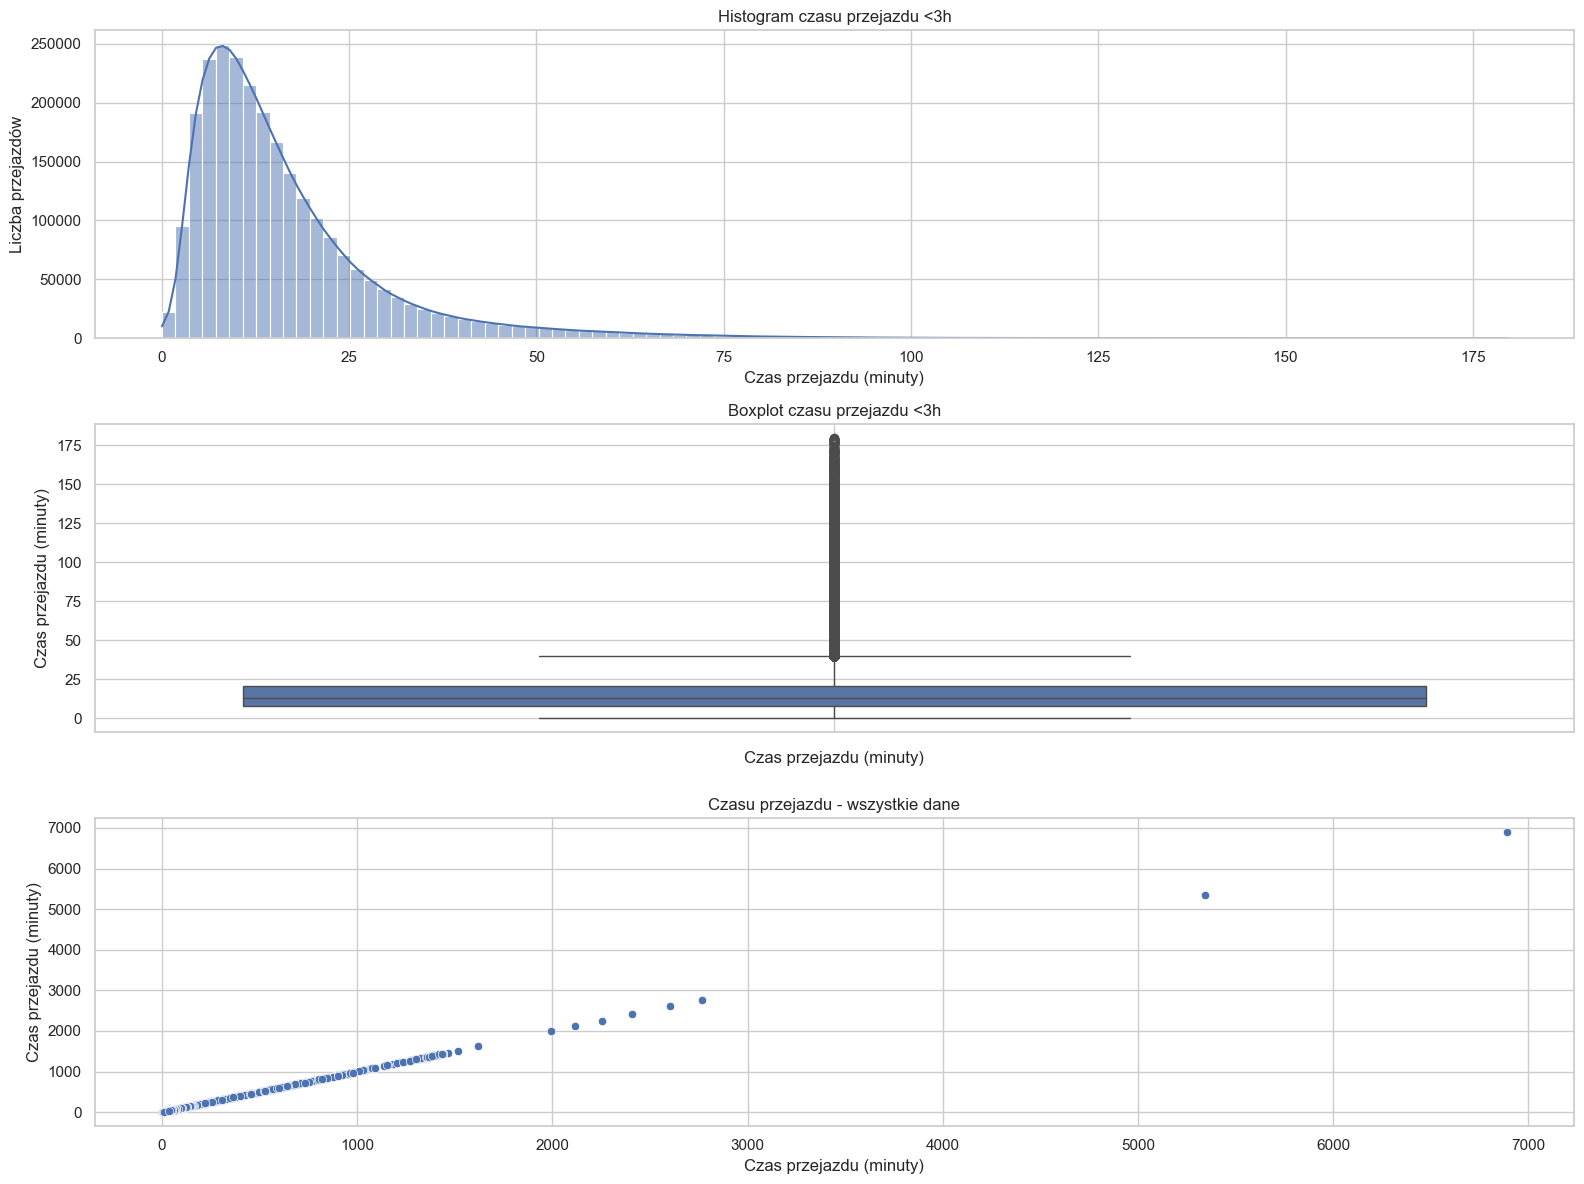

In [30]:
print(df['trip_duration'].describe())
fig, axes = plt.subplots(3,1,figsize=(16, 12))

# Histogram
sns.histplot(data=df[df['trip_duration']<180], x='trip_duration', bins=100, kde=True,ax=axes[0])
axes[0].set_title('Histogram czasu przejazdu <3h')
axes[0].set_xlabel('Czas przejazdu (minuty)')
axes[0].set_ylabel('Liczba przejazdów')
axes[0].grid(True)

# Boxplot
sns.boxplot(data=df[df['trip_duration']<180], y='trip_duration',ax=axes[1],orient='vertical')
axes[1].set_title('Boxplot czasu przejazdu <3h')
axes[1].set_xlabel('Czas przejazdu (minuty)')
axes[1].set_ylabel('Czas przejazdu (minuty)')
axes[1].grid(True)

# Scatter plot
sns.scatterplot(data=df, x='trip_duration', y='trip_duration', ax=axes[2])
axes[2].set_title('Czasu przejazdu - wszystkie dane')
axes[2].set_xlabel('Czas przejazdu (minuty)')
axes[2].set_ylabel('Czas przejazdu (minuty)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

**Rozkład danych wygląda normalnie dla większości przejazdów:**
- Typowy przejazd w NYC trwa około 13 minut (mediana)
- Większość kursów mieści się w przedziale 5-30 minut

**Problem z outlierami jest wyraźnie widoczny:**
- Pojawia się dużo wartości nierelaistycznych dla normalnej jazdy taksówką - powyżej 3 godzin
- Te wartości najprawdopodobniej powstały przez błędy w systemie, pozostawienie  włączonego taksometru podczas przerwy, lub bardzo nietypowe sytuacje

**Te anomalie mogą zaszkodzić modelowi, dlatego trzeba je usunąć:**
- Skrajnie długie czasy mogą sprawić, że model będzie się uczył nieprawidłowych wzorców
- W rzeczywistości pasażerowie i kierowcy nie potrzebują predykcji dla tak ekstremalnych przypadków
- Model powinien przewidywać normalne czasy przejazdu w typowych warunkach miejskich

In [31]:
max_duration = 180  
min_duration = 1   

print(f"Kryteria filtrowania czasu przejazdu: {min_duration}-{max_duration} minut")

duration_outliers = (df['trip_duration'] < min_duration) | (df['trip_duration'] > max_duration)
df_filtered = df[~duration_outliers]
print(f"Ilość outliers w czasie przejazd: {duration_outliers.sum()} rekordów")
print (f"Średnia czasu przed filtrowaniem: {df['trip_duration'].mean():.2f} minut")
print(f"Średnia czasu po filtrowaniu: {df_filtered['trip_duration'].mean():.2f} minut")


Kryteria filtrowania czasu przejazdu: 1-180 minut
Ilość outliers w czasie przejazd: 11191 rekordów
Średnia czasu przed filtrowaniem: 17.19 minut
Średnia czasu po filtrowaniu: 16.59 minut


**Uzasadnienie:**
- **3 godziny** to rozsądny maksimum dla przejazdu taksówką w NYC (w tym dojazdy na lotniska).

## 5.2 Analiza trip_distance

count    2.552176e+06
mean     5.892774e+00
std      5.414712e+02
min      1.000000e-02
25%      1.070000e+00
50%      1.800000e+00
75%      3.400000e+00
max      2.689582e+05
Name: trip_distance, dtype: float64


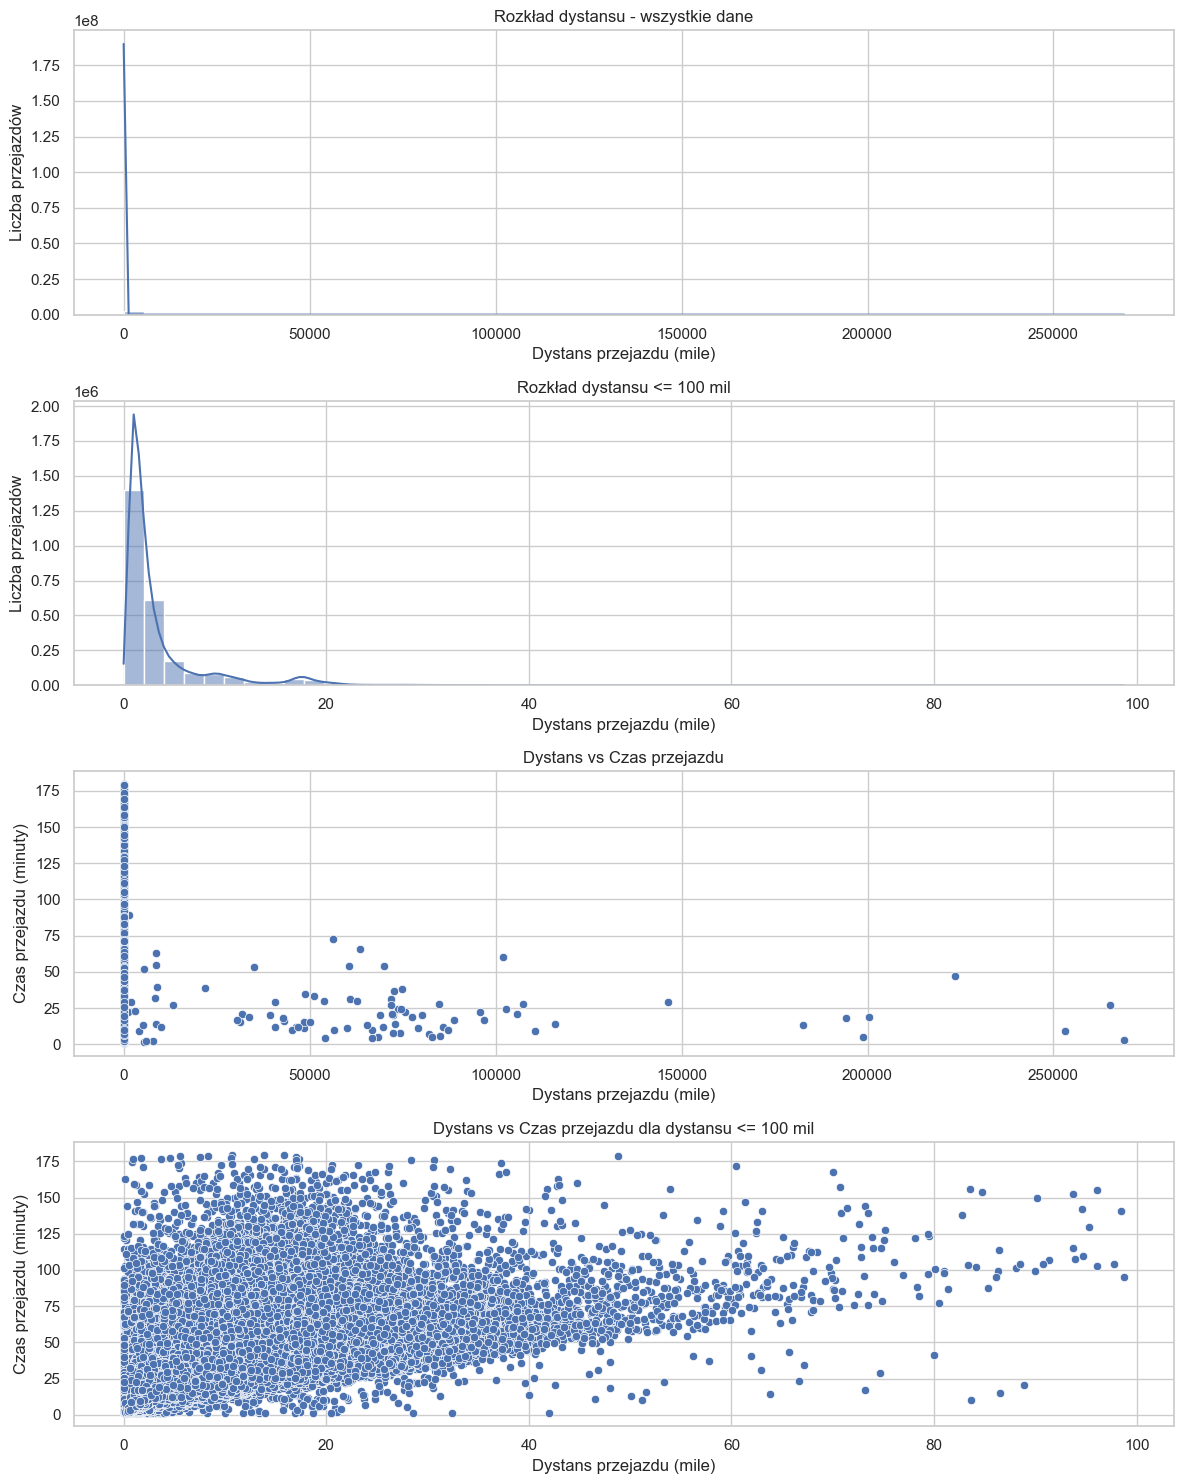

In [32]:
fig, axes = plt.subplots(4, 1, figsize=(12, 15))

print(df_filtered['trip_distance'].describe())

sns.histplot(data=df_filtered, x='trip_distance', bins=50, kde=True, ax=axes[0])
axes[0].set_title('Rozkład dystansu - wszystkie dane')
axes[0].set_xlabel('Dystans przejazdu (mile)')
axes[0].set_ylabel('Liczba przejazdów')
axes[0].grid(True)

sns.histplot(data=df_filtered[df_filtered['trip_distance'] <= 100], x='trip_distance', bins=50, kde=True, ax=axes[1])
axes[1].set_title('Rozkład dystansu <= 100 mil')
axes[1].set_xlabel('Dystans przejazdu (mile)')
axes[1].set_ylabel('Liczba przejazdów')
axes[1].grid(True)

sns.scatterplot(data=df_filtered, x='trip_distance', y='trip_duration', ax=axes[2])
axes[2].set_title('Dystans vs Czas przejazdu')
axes[2].set_xlabel('Dystans przejazdu (mile)')
axes[2].set_ylabel('Czas przejazdu (minuty)')
axes[2].grid(True)

sns.scatterplot(data=df_filtered[df_filtered['trip_distance']<=100], x='trip_distance', y='trip_duration', ax=axes[3])
axes[3].set_title('Dystans vs Czas przejazdu dla dystansu <= 100 mil')
axes[3].set_xlabel('Dystans przejazdu (mile)')
axes[3].set_ylabel('Czas przejazdu (minuty)')
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [33]:
df_filtered[df_filtered['trip_distance'] <0.1].head(50)

,tpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,trip_duration
669,2024-01-06 19:38:40,161,161,0.02,3.266667
2185,2024-01-06 16:43:45,164,164,0.02,2.116667
3206,2024-01-28 00:13:35,79,79,0.02,4.550000
3909,2024-01-27 19:07:51,249,249,0.05,1.216667
4022,2024-01-02 17:07:14,234,234,0.03,3.033333
6677,2024-01-07 19:40:28,246,48,0.06,5.850000
6766,2024-01-25 11:19:52,230,230,0.08,3.100000
8173,2024-01-23 09:41:02,229,229,0.08,1.200000
11448,2024-01-05 18:57:36,140,141,0.07,3.583333
11846,2024-01-17 20:46:55,132,132,0.01,4.083333


**Bardzo krótkie dystanse < 0.1 mili:**
- Błędy GPS - niedokładne pozycjonowanie 
- Przypadkowe włączenie taksometru bez ruchu
- Anulowane kursy po włączeniu licznika

In [34]:
df_filtered[df_filtered['trip_distance']>100].head(50)

,tpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,trip_duration
58844,2024-01-28 17:24:07,132,265,119.46,146.383333
62015,2024-01-24 04:31:22,48,265,155.56,140.933333
101379,2024-01-21 11:58:00,209,211,72975.97,14.000000
174922,2024-02-14 05:20:57,167,231,63515.20,65.983333
228741,2024-02-09 07:22:06,62,237,69928.10,54.333333
232612,2024-02-27 09:11:10,186,265,101.17,105.216667
277771,2024-02-05 20:44:11,132,265,127.70,160.016667
318995,2024-03-18 09:38:00,140,75,66838.02,10.000000
359692,2024-03-14 08:37:00,52,161,21921.85,39.000000
381235,2024-03-02 15:23:00,232,61,51144.52,33.000000


**Bardzo długie dystanse > 100 mil:**
- Przejazdy poza NYC (DOLocationID = 265 - "Outside of NYC" - taxi_zone_lookup.csv )
- Błędne dane z urządzeń pomiarowych
- Pozostawiony włączony taksometr na długi czas

In [35]:
max_distance = 100
min_distance = 0.1
print(f"Kryteria filtrowania dystansu: {min_distance}-{max_distance} mil")
distance_outliers = (df_filtered['trip_distance'] < min_distance) | (df_filtered['trip_distance'] > max_distance)
print(f"Ilość outliers w dystansie: {distance_outliers.sum()} rekordów")
print(f"Średnia dystansu przed filtrowaniem: {df_filtered['trip_distance'].mean():.2f} mil")
df_filtered = df_filtered[~distance_outliers]   
print(f"Średnia dystansu po filtrowaniu: {df_filtered['trip_distance'].mean():.2f} mil")


Kryteria filtrowania dystansu: 0.1-100 mil
Ilość outliers w dystansie: 6100 rekordów
Średnia dystansu przed filtrowaniem: 5.89 mil
Średnia dystansu po filtrowaniu: 3.40 mil


In [36]:
print(f"Korelacja między dystansem a czasem przejazdu: {df_filtered['trip_distance'].corr(df_filtered['trip_duration']):.2f}")

Korelacja między dystansem a czasem przejazdu: 0.79


**Charakterystyka rozkładu dystansu:**
- Większość przejazdów to krótkie trasy miejskie (1-5 mil)
- Mediana około 1-2 mile, typowe dla NYC

**Identyfikacja outliers:**
- Bardzo długie przejazdy > 100 mil 
- Bardzo krótkie dystanse < 0.1 mili

**Zastosowane kryteria:**
- Filtrowanie z użyciem przedziału [0.1, 100] mil pozwala wykluczyć nieprawidłowe dane.

## 5.3 Analiza średniej prędkości przejazdu

count    2.546076e+06
mean     1.100805e+01
std      6.978569e+00
min      5.150215e-02
25%      6.992806e+00
50%      9.380952e+00
75%      1.287805e+01
max      2.438710e+03
Name: avg_speed, dtype: float64


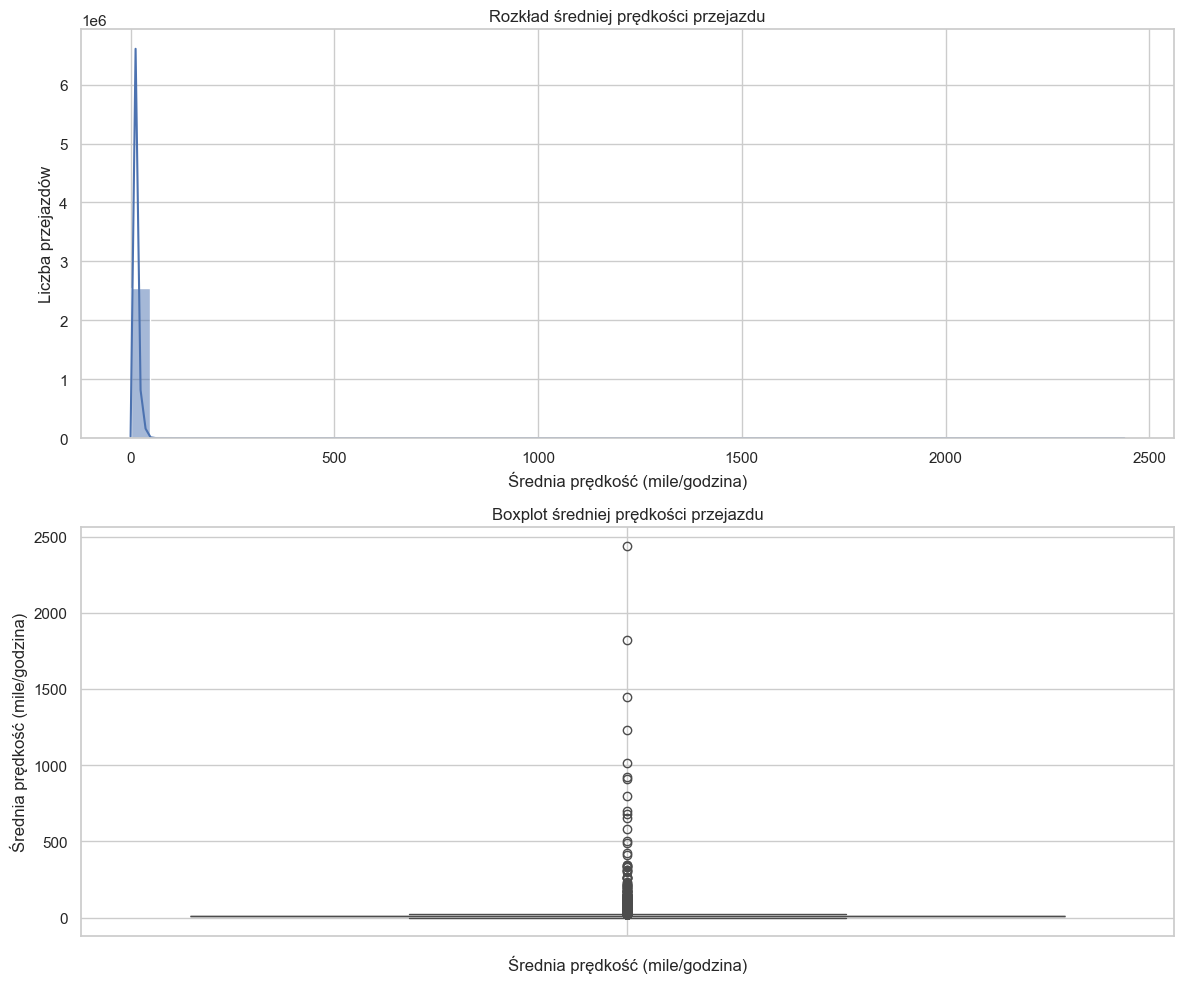

In [37]:
df_filtered['avg_speed'] = df_filtered['trip_distance'] / df_filtered['trip_duration'] * 60 
print(df_filtered['avg_speed'].describe())
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.histplot(data=df_filtered, x='avg_speed', bins=50, kde=True, ax=axes[0])
axes[0].set_title('Rozkład średniej prędkości przejazdu')
axes[0].set_xlabel('Średnia prędkość (mile/godzina)')
axes[0].set_ylabel('Liczba przejazdów')
axes[0].grid(True)

sns.boxplot(data=df_filtered, y='avg_speed', ax=axes[1])
axes[1].set_title('Boxplot średniej prędkości przejazdu')
axes[1].set_ylabel('Średnia prędkość (mile/godzina)')
axes[1].set_xlabel('Średnia prędkość (mile/godzina)')
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
q001 = df_filtered['avg_speed'].quantile(0.001)
q999 = df_filtered['avg_speed'].quantile(0.999)

print(f"Próg 0.1% średniej prędkości: {q001:.2f} mph, ilosć rekordów poniżej: {df_filtered[df_filtered['avg_speed'] < q001].shape[0]}")
print(f"Próg 99.9% średniej prędkości: {q999:.2f} mph,ilosć rekordów powyżej: {df_filtered[df_filtered['avg_speed'] > q999].shape[0]}")

Próg 0.5% średniej prędkości: 1.26 mph, ilosć rekordów poniżej: 2547
Próg 99.5% średniej prędkości: 45.67 mph,ilosć rekordów powyżej: 2547


count    2.540982e+06
mean     1.096897e+01
std      6.234638e+00
min      1.260000e+00
25%      6.997996e+00
50%      9.380952e+00
75%      1.286650e+01
max      4.566722e+01
Name: avg_speed, dtype: float64


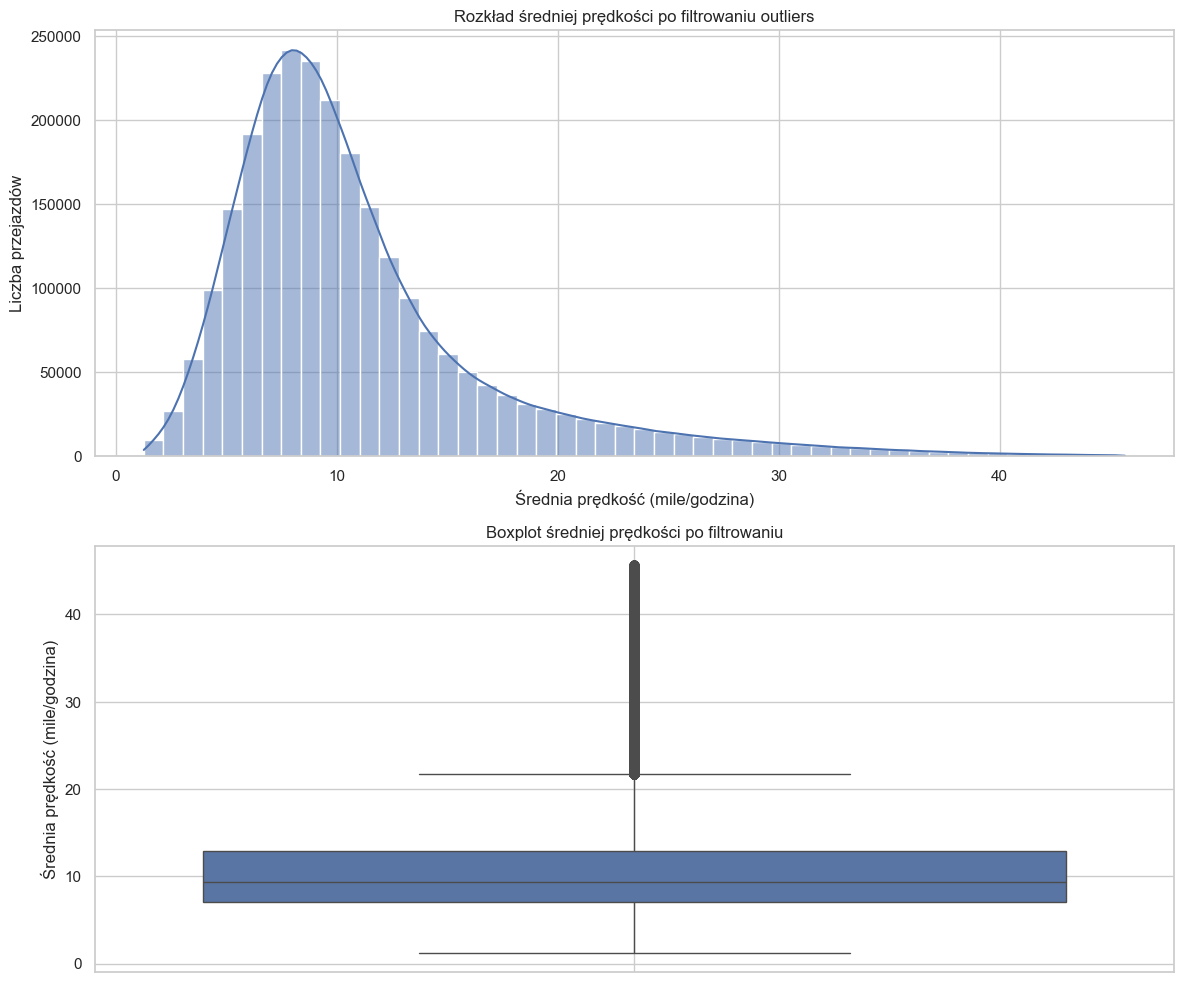

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
print(df_filtered[(df_filtered['avg_speed']>=q001) & (df_filtered['avg_speed'] <= q999)]['avg_speed'].describe())
sns.histplot(data=df_filtered[(df_filtered['avg_speed'] >= q001) & (df_filtered['avg_speed'] <= q999)], x='avg_speed', bins=50, kde=True, ax=axes[0])
axes[0].set_title('Rozkład średniej prędkości po filtrowaniu outliers')
axes[0].set_xlabel('Średnia prędkość (mile/godzina)')
axes[0].set_ylabel('Liczba przejazdów')
axes[0].grid(True)

sns.boxplot(data=df_filtered[(df_filtered['avg_speed'] >= q001) & (df_filtered['avg_speed'] <= q999)], y='avg_speed', ax=axes[1])
axes[1].set_title('Boxplot średniej prędkości po filtrowaniu')
axes[1].set_ylabel('Średnia prędkość (mile/godzina)')
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [40]:
df_filtered[df_filtered['avg_speed'] < q001].head(20)

,tpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,trip_duration,avg_speed
557,2024-01-29 09:32:18,81,163,0.90,74.466667,0.725157
3593,2024-01-31 12:09:15,162,162,0.20,12.200000,0.983607
5021,2024-01-28 01:52:36,90,231,0.10,13.216667,0.453972
8542,2024-01-27 18:38:56,79,79,0.10,5.916667,1.014085
11435,2024-01-16 10:05:25,237,43,0.20,13.350000,0.898876
11809,2024-01-24 06:21:55,69,226,0.80,52.316667,0.917490
16302,2024-01-25 10:55:43,161,237,0.24,14.583333,0.987429
22406,2024-01-17 08:28:55,162,161,0.40,21.133333,1.135647
22649,2024-01-11 18:51:37,230,230,0.21,120.416667,0.104637
25826,2024-01-30 18:27:19,249,249,0.19,11.183333,1.019374


In [41]:
df_filtered[df_filtered['avg_speed'] > q999].head(20)

,tpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,trip_duration,avg_speed
2447,2024-01-20 12:44:33,132,138,11.97,14.816667,48.472441
3455,2024-01-19 05:16:32,132,179,14.49,18.250000,47.638356
3654,2024-01-04 01:30:41,132,232,17.40,22.416667,46.572491
3738,2024-01-10 00:20:04,138,1,33.22,43.400000,45.926267
3849,2024-01-08 07:50:43,161,265,41.01,46.216667,53.240534
4543,2024-01-26 01:21:21,14,6,1.62,2.116667,45.921260
5581,2024-01-24 08:22:54,265,1,13.20,17.266667,45.868726
6703,2024-01-01 10:13:02,132,252,11.95,14.300000,50.139860
8221,2024-01-29 00:01:11,132,93,7.78,8.866667,52.646617
8730,2024-01-02 08:24:59,226,138,5.29,6.716667,47.255583


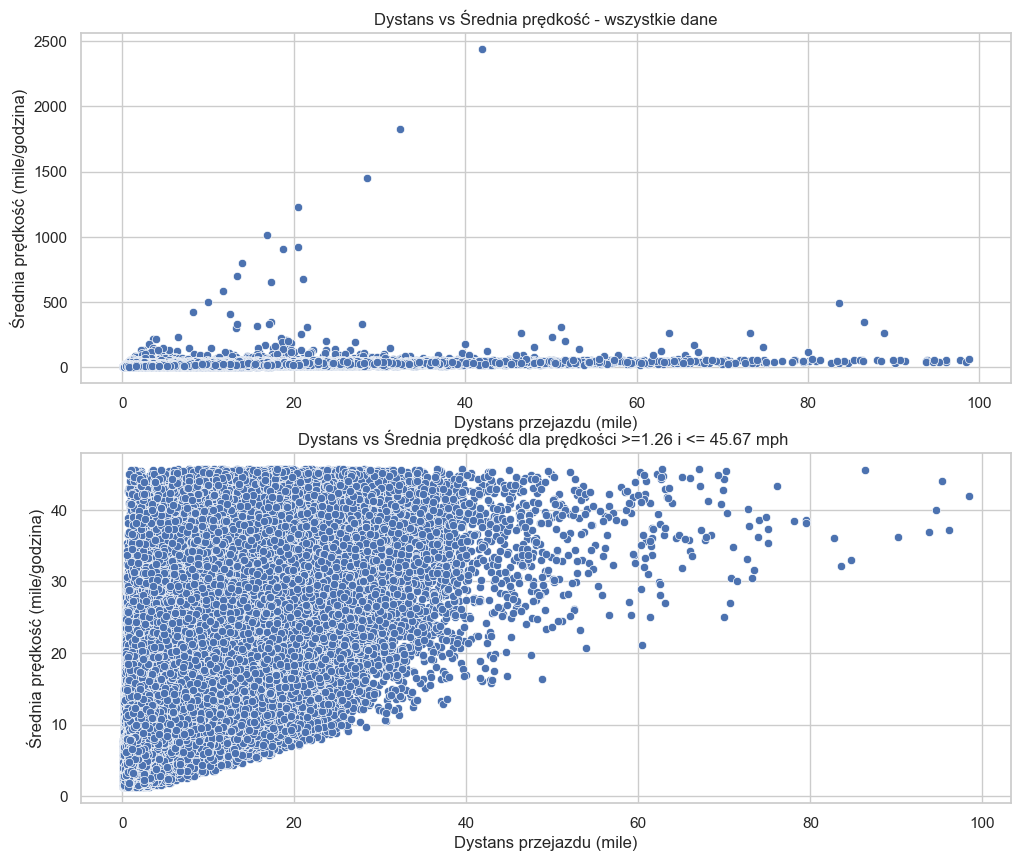

In [42]:
fig,axes = plt.subplots(2, 1, figsize=(12, 10))
sns.scatterplot(data=df_filtered, x='trip_distance', y='avg_speed', ax=axes[0])
axes[0].set_title('Dystans vs Średnia prędkość - wszystkie dane')
axes[0].set_xlabel('Dystans przejazdu (mile)')
axes[0].set_ylabel('Średnia prędkość (mile/godzina)')
axes[0].grid(True)

sns.scatterplot(data=df_filtered[(df_filtered['avg_speed']>=q001) & (df_filtered['avg_speed'] <= q999)], x='trip_distance', y='avg_speed', ax=axes[1])
axes[1].set_title(f'Dystans vs Średnia prędkość dla prędkości >={q001:.2f} i <= {q999:.2f} mph ')
axes[1].set_xlabel('Dystans przejazdu (mile)')
axes[1].set_ylabel('Średnia prędkość (mile/godzina)')
axes[1].grid(True)

In [43]:
print(f"Kryteria filtrowania dystansu: {min_distance}-{max_distance} mil")
avg_speed_outliers = (df_filtered['avg_speed'] < q001) | (df_filtered['avg_speed'] > q999)
print(f"Ilość outliers w średniej prędkości: {avg_speed_outliers.sum()} rekordów")
print(f"Średnia prędkości przed filtrowaniem: {df_filtered['avg_speed'].mean():.2f} mph")
df_filtered = df_filtered[(df_filtered['avg_speed'] >= q001) & (df_filtered['avg_speed'] <= q999)]
print(f"Średnia prędkości po filtrowaniu: {df_filtered['avg_speed'].mean():.2f} mph")

Kryteria filtrowania dystansu: 0.1-100 mil
Ilość outliers w średniej prędkości: 5094 rekordów
Średnia prędkości przed filtrowaniem: 11.01 mph
Średnia prędkości po filtrowaniu: 10.97 mph


**Charakterystyka rozkładu prędkości:**
- Typowa prędkość w NYC: 5-15 mph (ruch miejski z korkami)

**Problem z outlierami prędkości:**

**Bardzo niska prędkość (<1-2 mph):**
- Ekstremalne korki uliczne w godzinach szczytu
- Pozostawiony włączony taksometr podczas postoju

**Bardzo wysoka prędkość (>50 mph):**
- Przejazdy autostradami poza NYC
- Nieprawidłowe pomiary czasu/dystansu

**Zastosowane kryteria filtrowania:**
Percentyle 0.1%-99.9% eliminują skrajne anomalie, zachowując realistyczne warunki ruchu miejskiego w NYC.

## 5.4 Analiza sezonowości 

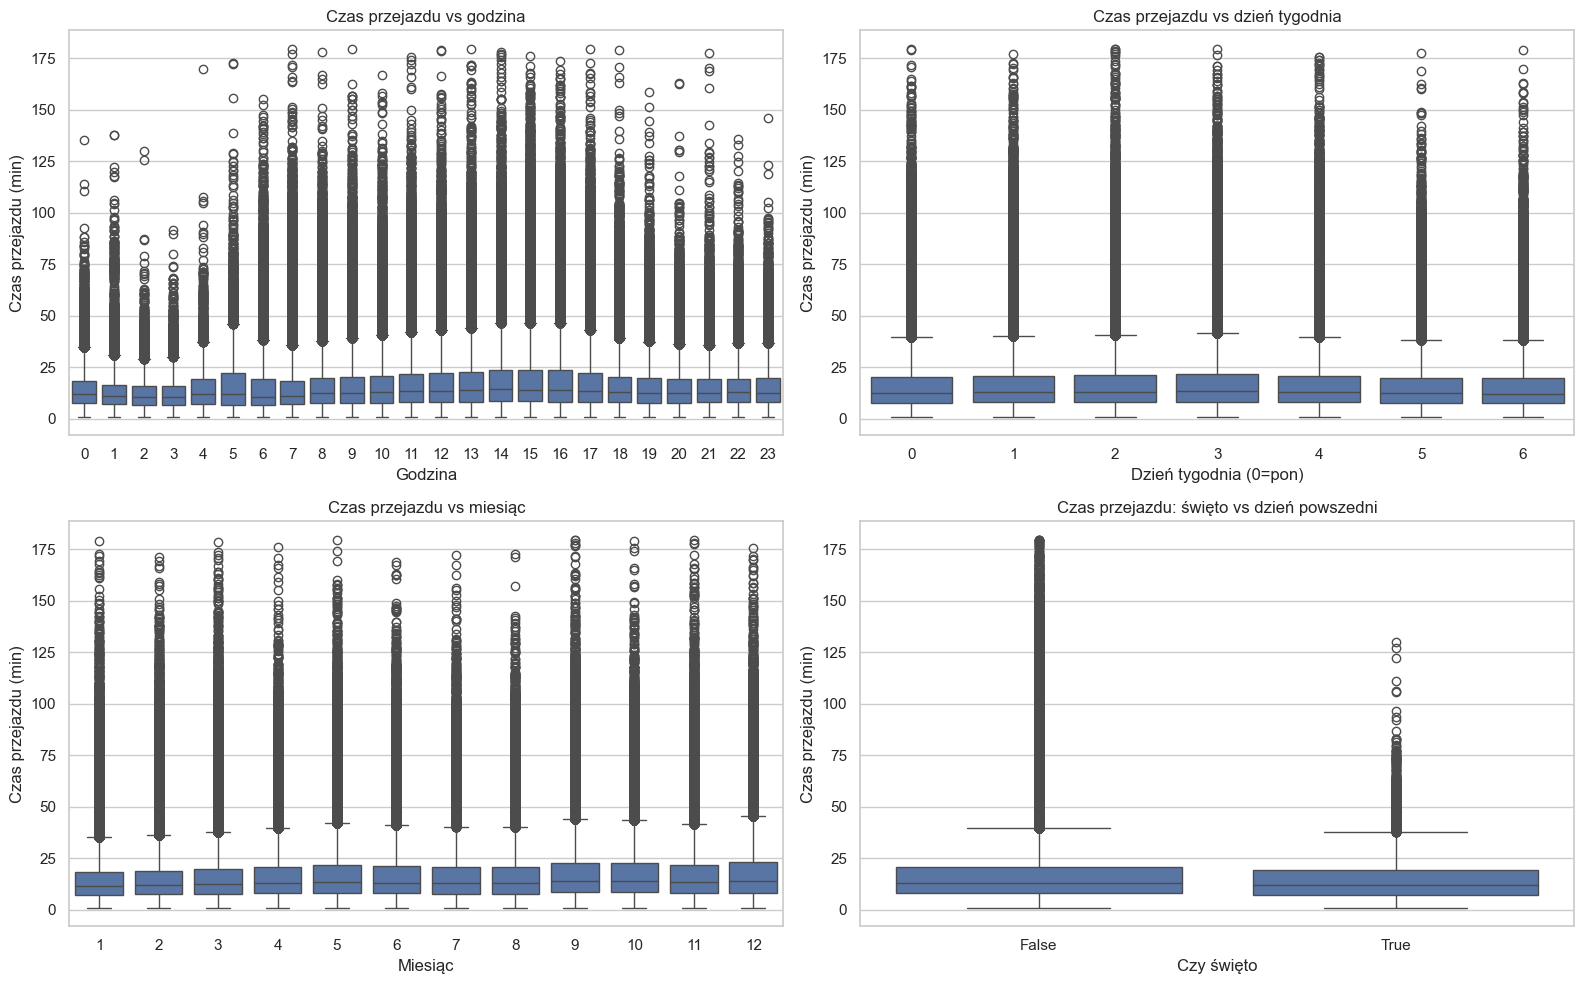

In [44]:
df_filtered['hour'] = df_filtered['tpep_pickup_datetime'].dt.hour
df_filtered['weekday'] = df_filtered['tpep_pickup_datetime'].dt.dayofweek 
df_filtered['month'] = df_filtered['tpep_pickup_datetime'].dt.month

holidays = [
    '01-01',  # Nowy Rok
    '12-24',  # Wigilia
    '12-25',  # Boże Narodzenie
    '12-31',  # Sylwester
]

df_filtered['is_holiday'] = (df_filtered['tpep_pickup_datetime'].dt.strftime('%m-%d').isin(holidays) )

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Godzina
sns.boxplot(data=df_filtered, x='hour', y='trip_duration', ax=axes[0,0])
axes[0,0].set_title('Czas przejazdu vs godzina')
axes[0,0].set_xlabel('Godzina')
axes[0,0].set_ylabel('Czas przejazdu (min)')

# Dzień tygodnia
sns.boxplot(data=df_filtered, x='weekday', y='trip_duration', ax=axes[0,1])
axes[0,1].set_title('Czas przejazdu vs dzień tygodnia')
axes[0,1].set_xlabel('Dzień tygodnia (0=pon)')
axes[0,1].set_ylabel('Czas przejazdu (min)')

# Miesiąc
sns.boxplot(data=df_filtered, x='month', y='trip_duration', ax=axes[1,0])
axes[1,0].set_title('Czas przejazdu vs miesiąc')
axes[1,0].set_xlabel('Miesiąc')
axes[1,0].set_ylabel('Czas przejazdu (min)')

# Święta
sns.boxplot(data=df_filtered,x='is_holiday', y='trip_duration', ax=axes[1,1])
axes[1,1].set_title('Czas przejazdu: święto vs dzień powszedni')
axes[1,1].set_xlabel('Czy święto')
axes[1,1].set_ylabel('Czas przejazdu (min)')

plt.tight_layout()
plt.show()

In [45]:
mean_duration_by_hour = df_filtered.groupby('hour')['trip_duration'].mean()
mean_distance_by_hour = df_filtered.groupby('hour')['trip_distance'].mean()
display("Średni czas przejazdu wg godziny:", mean_duration_by_hour)
display("Średni dystans przejazdu wg godziny:", mean_distance_by_hour)

'Średni czas przejazdu wg godziny:'

hour
0     14.324808
1     13.071379
2     12.220647
3     12.320111
4     14.259243
5     16.556173
6     16.381158
7     16.035324
8     16.100656
9     16.191763
10    16.443757
11    17.013720
12    17.398284
13    17.994984
14    19.151132
15    19.489870
16    19.462206
17    17.947914
18    16.209896
19    15.412168
20    14.950550
21    14.832174
22    15.131726
23    15.182307
Name: trip_duration, dtype: float64

'Średni dystans przejazdu wg godziny:'

hour
0     3.826940
1     3.372455
2     3.137764
3     3.487008
4     4.880772
5     6.002770
6     4.783594
7     3.698558
8     3.181115
9     3.122061
10    3.115571
11    3.086685
12    3.195832
13    3.355811
14    3.533254
15    3.480462
16    3.515782
17    3.141057
18    2.989060
19    3.186622
20    3.346276
21    3.408149
22    3.564901
23    3.870499
Name: trip_distance, dtype: float64

In [46]:
mean_duration_by_weekday = df_filtered.groupby('weekday')['trip_duration'].mean()
mean_distance_by_weekday = df_filtered.groupby('weekday')['trip_distance'].mean()
print("Średni czas przejazdu wg dnia tygodnia:", mean_duration_by_weekday)
print("Średni dystans przejazdu wg dnia tygodnia:", mean_distance_by_weekday)

Średni czas przejazdu wg dnia tygodnia: weekday
0    16.619565
1    16.846853
2    17.029335
3    17.477240
4    16.818008
5    15.629682
6    15.552244
Name: trip_duration, dtype: float64
Średni dystans przejazdu wg dnia tygodnia: weekday
0    3.722608
1    3.282673
2    3.223442
3    3.294102
4    3.337395
5    3.183163
6    3.789356
Name: trip_distance, dtype: float64


In [47]:
mean_duration_by_month = df_filtered.groupby('month')['trip_duration'].mean()
mean_distance_by_month = df_filtered.groupby('month')['trip_distance'].mean()
display("Średni czas przejazdu wg miesiąca:", mean_duration_by_month)
display("Średni dystans przejazdu wg miesiąca:", mean_distance_by_month)

'Średni czas przejazdu wg miesiąca:'

month
1     14.860990
2     15.214532
3     15.929150
4     16.451952
5     17.512203
6     17.051032
7     16.675623
8     16.713564
9     18.275077
10    17.842529
11    17.294278
12    18.274558
Name: trip_duration, dtype: float64

'Średni dystans przejazdu wg miesiąca:'

month
1     3.232104
2     3.166427
3     3.352865
4     3.392686
5     3.437630
6     3.445585
7     3.610785
8     3.657182
9     3.562472
10    3.504792
11    3.351732
12    3.356065
Name: trip_distance, dtype: float64

In [48]:
mean_duration_by_holiday = df_filtered.groupby('is_holiday')['trip_duration'].mean()
mean_distance_by_holiday = df_filtered.groupby('is_holiday')['trip_distance'].mean()
print("Średni czas przejazdu: święto vs dzień powszedni:\n", mean_duration_by_holiday)
print("\nŚredni dystans przejazdu: święto vs dzień powszedni:\n", mean_distance_by_holiday)

Średni czas przejazdu: święto vs dzień powszedni:
 is_holiday
False    16.596597
True     14.926799
Name: trip_duration, dtype: float64

Średni dystans przejazdu: święto vs dzień powszedni:
 is_holiday
False    3.386015
True     3.677976
Name: trip_distance, dtype: float64


## Analiza Sezonowości – Podsumowanie

- **Godzina (hour)**  
  - Najdłuższe przejazdy pojawiają się w godzinach 13-17 .  
  - Po 17 czas przejazdu zwykle spada.

- **Dzień tygodnia**  
  - W tygodniu (pon.–pt.) widać średni czas przejazdu jest zdecydowanie dłuższy niż w weekendy.  

- **Miesiąc (month)**  
  - Czas przejazdu nie zmienia się tak znacząco, jak w przypadku godziny i dnia tygodnia, choć możliwe są niewielkie wahania sezonowe (np. trudniejsze warunki zimą).

- **Dni świąteczne (is_holiday)**  
  - Podczas świąt (Nowy Rok, Boże Narodzenie, Sylwester) ruch jest mniejszy, więc średni czas przejazdu spada, pomimo wzrostu średniego dystansu.

## 5.5 Analiza lokalizacji

In [49]:
locations = pd.read_csv("data/taxi_zone_lookup.csv")
df_filtered = df_filtered.merge(locations, left_on='PULocationID', right_on='LocationID', how='left', suffixes=('', '_PU'))
df_filtered = df_filtered.merge(locations, left_on='DOLocationID', right_on='LocationID', how='left', suffixes=('', '_DO'))
df_filtered.head()

,tpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,trip_duration,avg_speed,hour,weekday,month,is_holiday,LocationID,Borough,Zone,service_zone,LocationID_DO,Borough_DO,Zone_DO,service_zone_DO
0,2024-01-23 17:03:27,163,246,2.50,22.483333,6.671609,17,1,1,False,163,Manhattan,Midtown North,Yellow Zone,246,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
1,2024-01-01 06:49:07,162,48,1.00,7.216667,8.314088,6,0,1,True,162,Manhattan,Midtown East,Yellow Zone,48,Manhattan,Clinton East,Yellow Zone
2,2024-01-10 13:15:53,186,143,3.50,21.050000,9.976247,13,2,1,False,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone,143,Manhattan,Lincoln Square West,Yellow Zone
3,2024-01-09 07:22:51,151,140,3.24,14.650000,13.269625,7,1,1,False,151,Manhattan,Manhattan Valley,Yellow Zone,140,Manhattan,Lenox Hill East,Yellow Zone
4,2024-01-13 09:19:00,24,48,3.77,11.000000,20.563636,9,5,1,False,24,Manhattan,Bloomingdale,Yellow Zone,48,Manhattan,Clinton East,Yellow Zone


In [50]:
top_routes = (
    df_filtered.groupby(['Zone', 'Zone_DO'])
      .size()
      .reset_index(name='count')
      .sort_values('count', ascending=False)
      .head(20)
)
display(top_routes)

,Zone,Zone_DO,count
26139,Upper East Side South,Upper East Side North,17457
25932,Upper East Side North,Upper East Side South,14847
26140,Upper East Side South,Upper East Side South,11455
25931,Upper East Side North,Upper East Side North,11376
17371,Midtown Center,Upper East Side South,8169
26076,Upper East Side South,Midtown Center,7312
17370,Midtown Center,Upper East Side North,6922
26441,Upper West Side South,Lincoln Square East,6584
15154,Lincoln Square East,Upper West Side South,6544
26077,Upper East Side South,Midtown East,6408


In [143]:
mean_time_top_routes = (
    df_filtered.groupby(['Zone', 'Zone_DO'])['trip_duration']
      .agg(count='size', avg_duration='mean')
      .sort_values('count', ascending=False)
      .head(20)
)
display(mean_time_top_routes)

,,count,avg_duration
Zone,Zone_DO,,
Upper East Side South,Upper East Side North,17457,7.309818
Upper East Side North,Upper East Side South,14847,8.100092
Upper East Side South,Upper East Side South,11455,5.843179
Upper East Side North,Upper East Side North,11376,4.852627
Midtown Center,Upper East Side South,8169,9.652020
Upper East Side South,Midtown Center,7312,10.460604
Midtown Center,Upper East Side North,6922,13.665708
Upper West Side South,Lincoln Square East,6584,6.133966
Lincoln Square East,Upper West Side South,6544,6.204702


In [51]:
mean_time_routes = (
    df_filtered.groupby(['Zone', 'Zone_DO'])['trip_duration']
      .mean()
      .reset_index()
      .sort_values('trip_duration', ascending=False)
      .head(20)
)
display(mean_time_routes)

,Zone,Zone_DO,trip_duration
21909,Saint Albans,Gowanus,179.400000
20814,Queens Village,Upper East Side South,176.350000
21694,Rockaway Park,Gramercy,171.516667
26125,Upper East Side South,Starrett City,171.216667
7953,East New York/Pennsylvania Avenue,Kingsbridge Heights,169.433333
12447,Homecrest,Forest Hills,167.883333
8053,East Tremont,Gravesend,167.033333
67,Alphabet City,Bronxdale,166.400000
28302,Woodhaven,Central Park,165.883333
23383,Spuyten Duyvil/Kingsbridge,Baisley Park,165.816667


In [52]:
df_filtered.groupby('Zone')['trip_duration'].mean().sort_values(ascending=False).head(10)

Zone
Far Rockaway           59.406892
Green-Wood Cemetery    57.983333
Hammels/Arverne        56.447589
Coney Island           49.710554
Brighton Beach         49.432663
Crotona Park           48.370833
Cambria Heights        47.781965
Laurelton              46.447363
Rosedale               45.769958
Pelham Bay             45.659836
Name: trip_duration, dtype: float64

In [53]:
df_filtered.groupby('Zone_DO')['trip_duration'].mean().sort_values(ascending=False).head(10)

Zone_DO
Arden Heights                        70.442857
Eltingville/Annadale/Prince's Bay    65.930159
Charleston/Tottenville               59.488235
Great Kills                          56.661111
Oakwood                              52.535417
Heartland Village/Todt Hill          52.325595
Port Richmond                        52.307407
Rossville/Woodrow                    49.483333
Hammels/Arverne                      49.243506
Saint George/New Brighton            48.923856
Name: trip_duration, dtype: float64

In [54]:
df_filtered['service_zone'].unique()

array(['Yellow Zone', 'Boro Zone', 'Airports', nan, 'EWR'], dtype=object)

In [55]:
df_filtered[(df_filtered['service_zone']=='Airports') | (df_filtered['service_zone']=='EWR')]

,tpep_pickup_datetime,PULocationID,DOLocationID,trip_distance,trip_duration,avg_speed,hour,weekday,month,is_holiday,LocationID,Borough,Zone,service_zone,LocationID_DO,Borough_DO,Zone_DO,service_zone_DO
22,2024-01-07 09:00:13,138,92,4.20,13.666667,18.439024,9,6,1,False,138,Queens,LaGuardia Airport,Airports,92,Queens,Flushing,Boro Zone
24,2024-01-20 14:51:04,132,48,18.90,53.400000,21.235955,14,5,1,False,132,Queens,JFK Airport,Airports,48,Manhattan,Clinton East,Yellow Zone
28,2024-01-05 20:23:51,138,35,12.35,27.550000,26.896552,20,4,1,False,138,Queens,LaGuardia Airport,Airports,35,Brooklyn,Brownsville,Boro Zone
48,2024-01-01 15:37:56,132,48,32.40,74.366667,26.140744,15,0,1,True,132,Queens,JFK Airport,Airports,48,Manhattan,Clinton East,Yellow Zone
64,2024-01-02 05:10:02,132,135,7.90,11.433333,41.457726,5,1,1,False,132,Queens,JFK Airport,Airports,135,Queens,Kew Gardens Hills,Boro Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540870,2025-03-13 13:30:51,138,13,15.50,36.266667,25.643382,13,3,3,False,138,Queens,LaGuardia Airport,Airports,13,Manhattan,Battery Park City,Yellow Zone
2540881,2025-03-12 15:11:04,132,95,7.42,32.200000,13.826087,15,2,3,False,132,Queens,JFK Airport,Airports,95,Queens,Forest Hills,Boro Zone
2540901,2025-03-18 15:33:09,132,107,16.80,52.666667,19.139241,15,1,3,False,132,Queens,JFK Airport,Airports,107,Manhattan,Gramercy,Yellow Zone
2540906,2025-03-23 22:02:48,138,249,11.76,26.733333,26.394015,22,6,3,False,138,Queens,LaGuardia Airport,Airports,249,Manhattan,West Village,Yellow Zone


In [56]:
df_filtered['is_airport_pickup'] = df_filtered['service_zone'].isin(['EWR', 'Airports'])
df_filtered['is_airport_dropoff'] = df_filtered['service_zone_DO'].isin(['EWR', 'Airports'])

airport_counts = pd.DataFrame({
    'pickup_airport': [df_filtered['is_airport_pickup'].sum()],
    'dropoff_airport': [df_filtered['is_airport_dropoff'].sum()]
})
display(airport_counts)

airport_stats = pd.DataFrame({
    'średni czas z lotniska': [df_filtered[df_filtered['is_airport_pickup']]['trip_duration'].mean()],
    'średni czas na lotnisko': [df_filtered[df_filtered['is_airport_dropoff']]['trip_duration'].mean()],
    'średni czas pozostałe': [df_filtered[~(df_filtered['is_airport_pickup'] | df_filtered['is_airport_dropoff'])]['trip_duration'].mean()]
})
display(airport_stats)

airport_distance = pd.DataFrame({
    'średni dystans z lotniska': [df_filtered[df_filtered['is_airport_pickup']]['trip_distance'].mean()],
    'średni dystans na lotnisko': [df_filtered[df_filtered['is_airport_dropoff']]['trip_distance'].mean()],
    'średni dystans pozostałe': [df_filtered[~(df_filtered['is_airport_pickup'] | df_filtered['is_airport_dropoff'])]['trip_distance'].mean()]
})
display(airport_distance)

,pickup_airport,dropoff_airport
0,192620,58129


,średni czas z lotniska,średni czas na lotnisko,średni czas pozostałe
0,38.325178,38.778353,14.211749


,średni dystans z lotniska,średni dystans na lotnisko,średni dystans pozostałe
0,13.407443,13.460896,2.30402


## Analiza lokalizacji – podsumowanie

- **Najpopularniejsze trasy:**  
  Najwięcej kursów realizowanych jest pomiędzy strefami położonymi w centrum Manhattanu (np. Midtown, Upper East Side, Upper West Side). Wskazuje to na największe natężenie ruchu w śródmieściu.

- **Średni czas przejazdu dla tras:**  
   Najczęstsze trasy to zazwyczaj krótkie przejazdy miejskie (średnio kilka/kilkanaście minut).

- **Dłuższe kursy:**  
  Najdłuższe czasy przejazdu dotyczą tras prowadzących na obrzeża miasta oraz kursów lotniskowych.

- **Kursy z/do lotnisk:**  
  Przejazdy rozpoczynające się lub kończące na lotniskach są wyraźnie dłuższe zarówno pod względem czasu, jak i dystansu. Stanowią istotną część wszystkich kursów.

In [57]:
df_filtered.columns

Index(['tpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_distance',
       'trip_duration', 'avg_speed', 'hour', 'weekday', 'month', 'is_holiday',
       'LocationID', 'Borough', 'Zone', 'service_zone', 'LocationID_DO',
       'Borough_DO', 'Zone_DO', 'service_zone_DO', 'is_airport_pickup',
       'is_airport_dropoff'],
      dtype='object')

In [58]:
df_filtered.drop(columns=['tpep_pickup_datetime','PULocationID', 'DOLocationID','avg_speed',
                           'LocationID','Borough','service_zone', 'LocationID_DO','Borough_DO','service_zone_DO'], inplace=True)
df_filtered.columns

Index(['trip_distance', 'trip_duration', 'hour', 'weekday', 'month',
       'is_holiday', 'Zone', 'Zone_DO', 'is_airport_pickup',
       'is_airport_dropoff'],
      dtype='object')

# 6. Inżynieria cech oraz usuwanie outlierów z całego zbioru danych

Wszystkie oczyszczone pliki Parquet są wczytywane i łączone w jeden DataFrame. Następnie losowana jest próbka 1 mln rekordów, ze względu na ograniczenia wydajnościowe.

In [59]:
print("Wczytywanie i łączenie wszystkich oczyszczonych plików...")
all_dfs = []
cleaned_files = list(Path("data/cleaned").glob("*.parquet"))

for file in cleaned_files:
    try:
        df = pd.read_parquet(file)
        all_dfs.append(df)
        print(f"Wczytano {file.name}: {len(df):,} rekordów")
    except Exception as e:
        print(f"Błąd podczas wczytywania {file.name}: {e}")
df_full = pd.concat(all_dfs, ignore_index=True)
df_full = df_full.sample(n=1_000_000, random_state=42)
print(f"Łączna liczba rekordów po połączeniu: {len(df_full):,}")

Wczytywanie i łączenie wszystkich oczyszczonych plików...
Wczytano yellow_tripdata_2024-01.parquet: 2,904,141 rekordów
Wczytano yellow_tripdata_2024-02.parquet: 2,939,258 rekordów
Wczytano yellow_tripdata_2024-03.parquet: 3,495,270 rekordów
Wczytano yellow_tripdata_2024-04.parquet: 3,468,346 rekordów
Wczytano yellow_tripdata_2024-05.parquet: 3,673,950 rekordów
Wczytano yellow_tripdata_2024-06.parquet: 3,486,179 rekordów
Wczytano yellow_tripdata_2024-07.parquet: 3,028,800 rekordów
Wczytano yellow_tripdata_2024-08.parquet: 2,921,720 rekordów
Wczytano yellow_tripdata_2024-09.parquet: 3,551,821 rekordów
Wczytano yellow_tripdata_2024-10.parquet: 3,752,056 rekordów
Wczytano yellow_tripdata_2024-11.parquet: 3,576,933 rekordów
Wczytano yellow_tripdata_2024-12.parquet: 3,592,555 rekordów
Wczytano yellow_tripdata_2025-01.parquet: 3,382,974 rekordów
Wczytano yellow_tripdata_2025-02.parquet: 3,473,274 rekordów
Wczytano yellow_tripdata_2025-03.parquet: 4,020,017 rekordów
Łączna liczba rekordów po p

Dane są łączone z tabelą stref NYC, co umożliwia dodanie nazw i typów stref początkowych oraz końcowych. Tworzone są także cechy czasowe (godzina, dzień tygodnia, miesiąc) oraz flagi dotyczące święta, kursów z/do lotniska. 

In [60]:
df_full = df_full.merge(locations, left_on='PULocationID', right_on='LocationID', how='left', suffixes=('', '_PU'))
df_full = df_full.merge(locations, left_on='DOLocationID', right_on='LocationID', how='left', suffixes=('', '_DO'))

df_full['hour'] = df_full['tpep_pickup_datetime'].dt.hour
df_full['weekday'] = df_full['tpep_pickup_datetime'].dt.dayofweek 
df_full['month'] = df_full['tpep_pickup_datetime'].dt.month

holidays = ['01-01', '12-24', '12-25', '12-31']
df_full['is_holiday'] = df_full['tpep_pickup_datetime'].dt.strftime('%m-%d').isin(holidays)

df_full['is_airport_pickup'] = df_full['service_zone'].isin(['EWR', 'Airports'])
df_full['is_airport_dropoff'] = df_full['service_zone_DO'].isin(['EWR', 'Airports'])

df_full.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,trip_duration,LocationID,Borough,Zone,service_zone,LocationID_DO,Borough_DO,Zone_DO,service_zone_DO,hour,weekday,month,is_holiday,is_airport_pickup,is_airport_dropoff
0,2024-11-10 18:03:35,2024-11-10 18:24:39,161,125,2.83,21.066667,161,Manhattan,Midtown Center,Yellow Zone,125,Manhattan,Hudson Sq,Yellow Zone,18,6,11,False,False,False
1,2024-08-24 02:08:43,2024-08-24 02:20:41,79,13,2.20,11.966667,79,Manhattan,East Village,Yellow Zone,13,Manhattan,Battery Park City,Yellow Zone,2,5,8,False,False,False
2,2025-02-03 07:39:18,2025-02-03 07:43:25,237,162,1.00,4.116667,237,Manhattan,Upper East Side South,Yellow Zone,162,Manhattan,Midtown East,Yellow Zone,7,0,2,False,False,False
3,2025-02-09 11:11:01,2025-02-09 11:29:52,211,236,4.99,18.850000,211,Manhattan,SoHo,Yellow Zone,236,Manhattan,Upper East Side North,Yellow Zone,11,6,2,False,False,False
4,2024-10-01 16:21:19,2024-10-01 16:26:42,186,90,0.67,5.383333,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone,90,Manhattan,Flatiron,Yellow Zone,16,1,10,False,False,False


In [61]:
df_full['avg_speed'] = df_full['trip_distance'] / df_full['trip_duration'] * 60

Usuwane są rekordy z nietypowymi wartościami czasu przejazdu, dystansu oraz prędkości. Dzięki temu eliminowane są błędne lub ekstremalne przypadki, które mogłyby negatywnie wpłynąć na jakość modelu.

In [62]:
# 1. Filtrowanie czasu przejazdu (1-180 min)
duration_mask = (df_full['trip_duration'] >= 1) & (df_full['trip_duration'] <= 180)
print(f"Outliers czas przejazdu: {(~duration_mask).sum():,} rekordów")

# 2. Filtrowanie dystansu (0.1-100 mil)
distance_mask = (df_full['trip_distance'] >= 0.1) & (df_full['trip_distance'] <= 100)
print(f"Outliers dystans: {(~distance_mask).sum():,} rekordów")

# 3. Filtrowanie prędkości (percentyle 0.1%-99.9%)
q001 = df_full['avg_speed'].quantile(0.001)
q999 = df_full['avg_speed'].quantile(0.999)
speed_mask = (df_full['avg_speed'] >= q001) & (df_full['avg_speed'] <= q999)
print(f"Outliers prędkość ({q001:.2f}-{q999:.2f} mph): {(~speed_mask).sum():,} rekordów")

combined_mask = duration_mask & distance_mask & speed_mask
df_full_no_outliers = df_full[combined_mask]

print(f"\nDane po filtrowaniu outliers: {df_full_no_outliers.shape}")
print(f"Usunięto łącznie: {len(df_full) - len(df_full_no_outliers):,} rekordów")

Outliers czas przejazdu: 4,411 rekordów
Outliers dystans: 4,922 rekordów
Outliers prędkość (0.06-47.69 mph): 2,000 rekordów

Dane po filtrowaniu outliers: (992678, 21)
Usunięto łącznie: 7,322 rekordów


Usuwane są zbędne kolumny, pozostają tylko te zmienne, które będą wykorzystywane w modelowaniu. Gotowy zbiór danych jest zapisywany i przekazywany do dalszego preprocessingu.

In [63]:
df_ready_to_preprocess = df_full_no_outliers.drop(columns=[
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'PULocationID', 'DOLocationID', 
    'avg_speed', 
    'LocationID', 'Borough', 'service_zone',
    'LocationID_DO', 'Borough_DO', 'service_zone_DO'
])
print(f"\nStatystyki finalnego zbioru:")
print(f"Rozmiar: {df_ready_to_preprocess.shape}")
print(f"\nPodstawowe statystyki zmiennej docelowej:")
print(df_ready_to_preprocess['trip_duration'].describe())
print("Finalne kolumny:", df_ready_to_preprocess.columns.tolist())


Statystyki finalnego zbioru:
Rozmiar: (992678, 10)

Podstawowe statystyki zmiennej docelowej:
count    992678.000000
mean         16.614847
std          13.378725
min           1.000000
25%           7.950000
50%          12.916667
75%          20.716667
max         178.083333
Name: trip_duration, dtype: float64
Finalne kolumny: ['trip_distance', 'trip_duration', 'Zone', 'Zone_DO', 'hour', 'weekday', 'month', 'is_holiday', 'is_airport_pickup', 'is_airport_dropoff']


## Zmienne wejściowe i wyjściowe do modelowania

**Cechy wejściowe:**
- `trip_distance` – dystans przejazdu (mile)
- `Zone` – nazwa strefy początkowej (kategoria)
- `Zone_DO` – nazwa strefy docelowej (kategoria)
- `hour` – godzina rozpoczęcia kursu (0–23)
- `weekday` – dzień tygodnia (0=poniedziałek, 6=niedziela)
- `month` – miesiąc (1–12)
- `is_holiday` – czy kurs odbywa się w dzień świąteczny (0/1)
- `is_airport_pickup` – czy kurs rozpoczyna się na lotnisku (0/1)
- `is_airport_dropoff` – czy kurs kończy się na lotnisku (0/1)

**Zmienna wyjściowa (target):**
- `trip_duration` – czas trwania przejazdu (minuty)

In [64]:
display(df_ready_to_preprocess.head(10))
display(df_ready_to_preprocess.info())

,trip_distance,trip_duration,Zone,Zone_DO,hour,weekday,month,is_holiday,is_airport_pickup,is_airport_dropoff
0,2.83,21.066667,Midtown Center,Hudson Sq,18,6,11,False,False,False
1,2.20,11.966667,East Village,Battery Park City,2,5,8,False,False,False
2,1.00,4.116667,Upper East Side South,Midtown East,7,0,2,False,False,False
3,4.99,18.850000,SoHo,Upper East Side North,11,6,2,False,False,False
4,0.67,5.383333,Penn Station/Madison Sq West,Flatiron,16,1,10,False,False,False
5,1.95,11.866667,Murray Hill,Meatpacking/West Village West,19,1,1,False,False,False
6,1.18,4.683333,East Harlem North,Randalls Island,16,1,10,False,False,False
7,1.20,6.450000,Central Park,Central Park,14,0,9,False,False,False
8,0.91,8.216667,Lincoln Square East,Times Sq/Theatre District,21,5,3,False,False,False
9,1.51,16.233333,Midtown East,Clinton West,17,2,1,False,False,False


<class 'pandas.core.frame.DataFrame'>
Index: 992678 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_distance       992678 non-null  float64
 1   trip_duration       992678 non-null  float64
 2   Zone                990028 non-null  object 
 3   Zone_DO             989063 non-null  object 
 4   hour                992678 non-null  int32  
 5   weekday             992678 non-null  int32  
 6   month               992678 non-null  int32  
 7   is_holiday          992678 non-null  bool   
 8   is_airport_pickup   992678 non-null  bool   
 9   is_airport_dropoff  992678 non-null  bool   
dtypes: bool(3), float64(2), int32(3), object(2)
memory usage: 52.1+ MB


None

In [65]:
df_ready_to_preprocess.to_parquet("data/ready_to_preprocess.parquet", index=False)
print("Zapisano zbiór")

Zapisano zbiór


# 7. Preprocessing

## 7.1 Skalowanie trip_duration

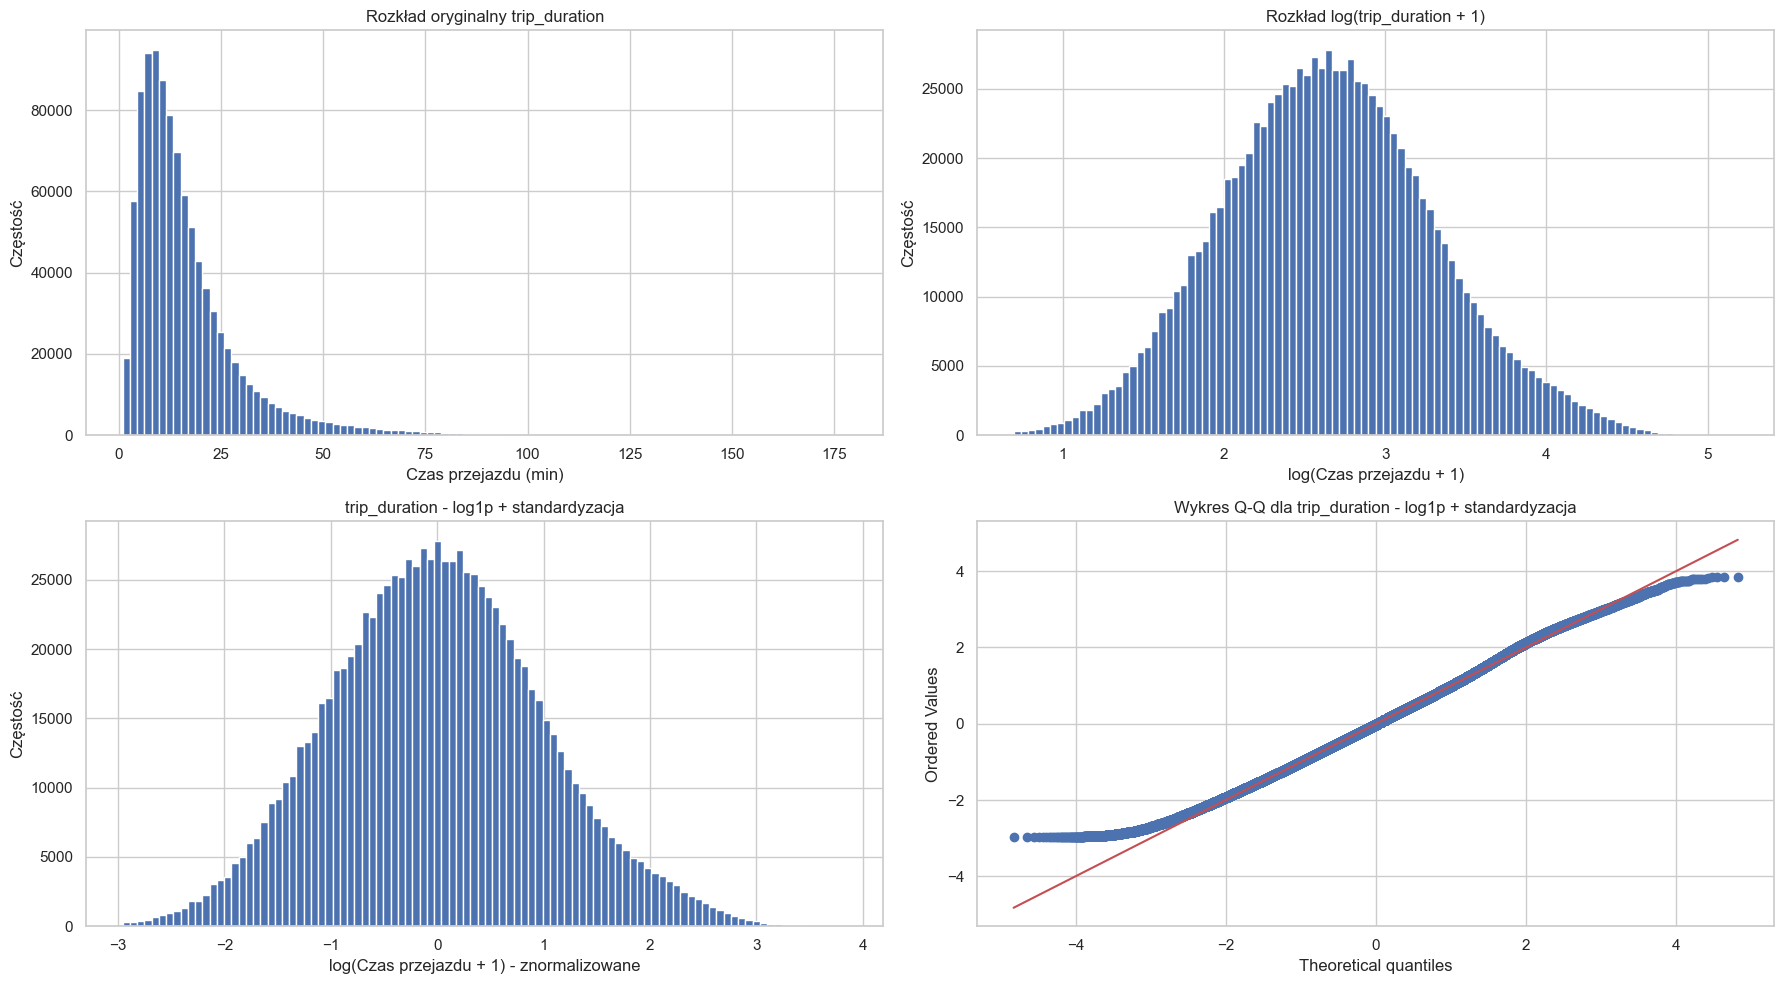

In [74]:
df = pd.read_parquet("data/ready_to_preprocess.parquet")

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].hist(df['trip_duration'], bins=100)
axes[0,0].set_title('Rozkład oryginalny trip_duration')
axes[0,0].set_xlabel('Czas przejazdu (min)')
axes[0,0].set_ylabel('Częstość')

log_duration = np.log1p(df['trip_duration'])
axes[0,1].hist(log_duration, bins=100)
axes[0,1].set_title('Rozkład log(trip_duration + 1)')
axes[0,1].set_xlabel('log(Czas przejazdu + 1)')
axes[0,1].set_ylabel('Częstość')

scaler_duration = StandardScaler()
scaled_duration = scaler_duration.fit_transform(log_duration.values.reshape(-1, 1)).flatten()
axes[1,0].hist(scaled_duration, bins=100)
axes[1,0].set_title('trip_duration - log1p + standardyzacja')
axes[1,0].set_xlabel('log(Czas przejazdu + 1) - znormalizowane')
axes[1,0].set_ylabel('Częstość')

stats.probplot(scaled_duration, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Wykres Q-Q dla trip_duration - log1p + standardyzacja')

plt.tight_layout()
plt.show()

In [75]:
def show_stats(x, name):
    skew  = stats.skew(x)
    kurt  = stats.kurtosis(x)
    print(f"{name:12} | skew={skew:6.2f} | kurt={kurt:6.2f}")
show_stats(df['trip_duration'].values, 'original')
show_stats(log_duration.values, 'log1p+duration')

original     | skew=  2.42 | kurt=  9.13
log1p+duration | skew=  0.14 | kurt= -0.09


- **Histogram oryginalnych wartości:**  
  Widać, że większość kursów trwa krótko, ale występują również długie przejazdy – rozkład jest mocno skośny. 

- **Histogram po transformacji logarytmicznej (`log1p`):**  
  Rozkład staje się bardziej symetryczny, a wpływ ekstremalnie długich kursów jest zredukowany.  

- **Histogram po standaryzacji:**  
  Dane mają średnią 0 i odchylenie 1, co jest korzystne dla większości algorytmów. Model szybciej i stabilniej się uczy.

- **Wykres Q-Q:**  
  Po obu transformacjach rozkład czasu przejazdu o wiele bardziej przypomina rozkład normalny (punkty pokrywają się z linią). 

# 7.2 Skalowanie trip-distance

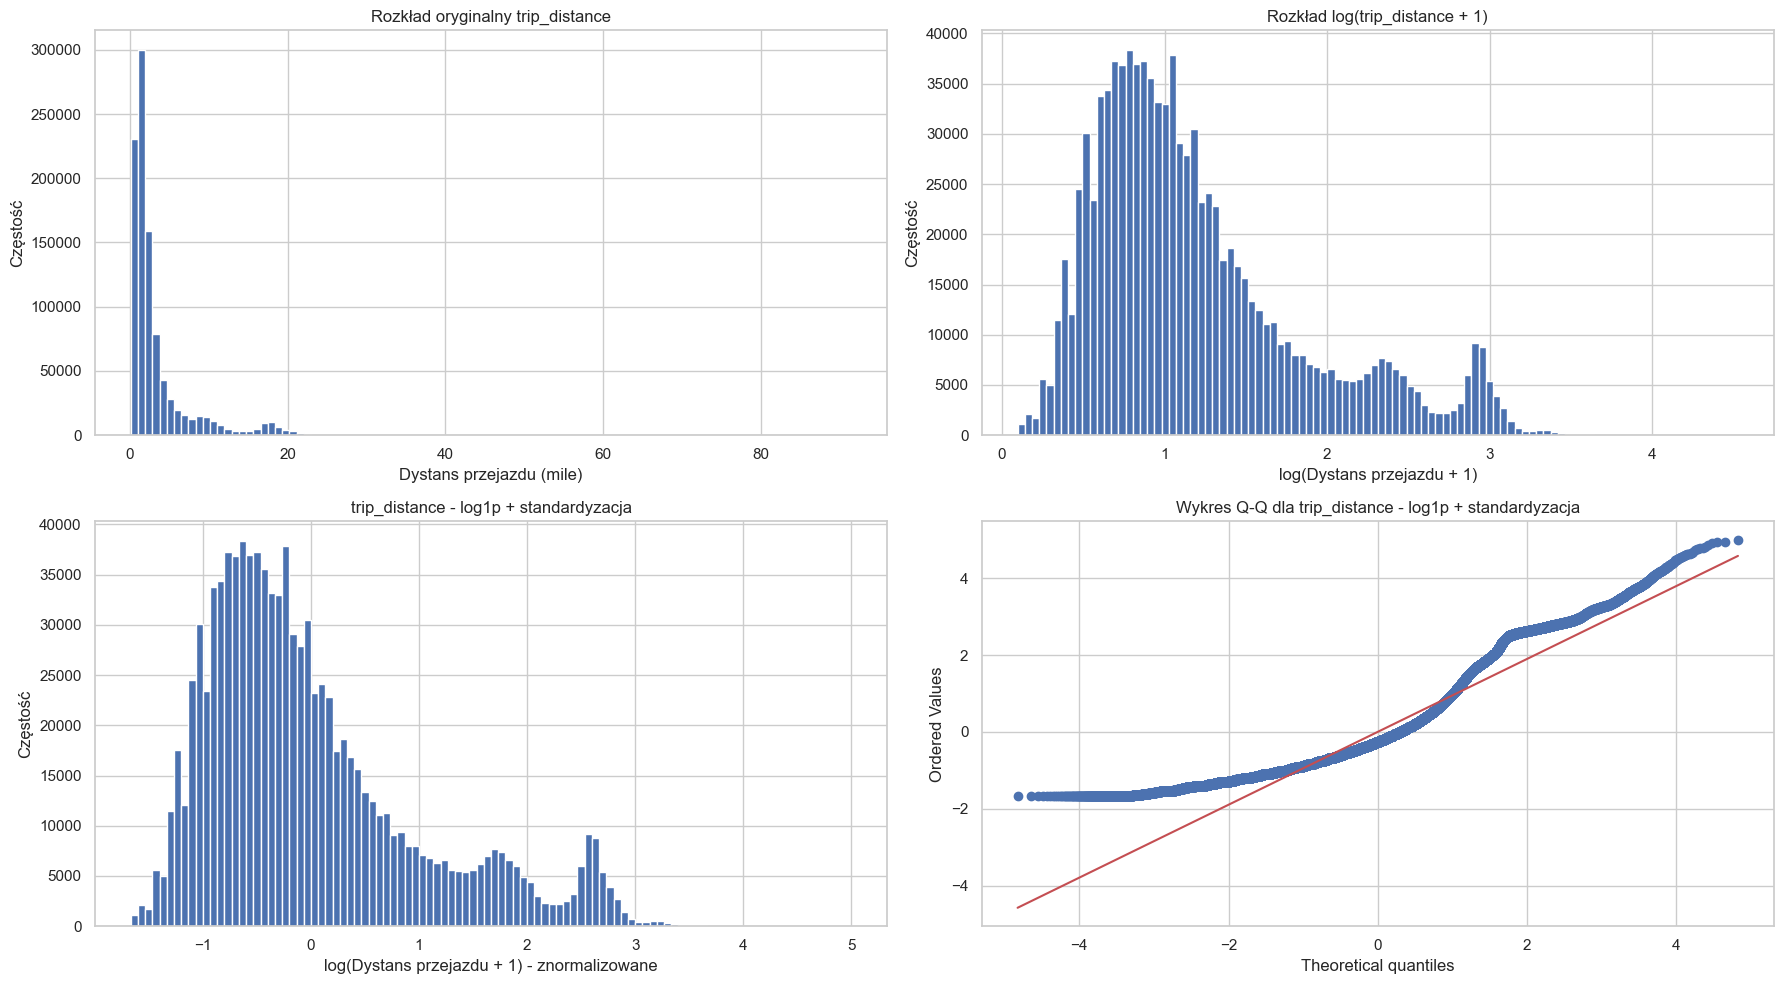

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].hist(df['trip_distance'], bins=100)
axes[0,0].set_title('Rozkład oryginalny trip_distance')
axes[0,0].set_xlabel('Dystans przejazdu (mile)')
axes[0,0].set_ylabel('Częstość')

log_distance = np.log1p(df['trip_distance'])
axes[0,1].hist(log_distance, bins=100)
axes[0,1].set_title('Rozkład log(trip_distance + 1)')
axes[0,1].set_xlabel('log(Dystans przejazdu + 1)')
axes[0,1].set_ylabel('Częstość')

scaler_distance = StandardScaler()
scaled_distance = scaler_distance.fit_transform(log_distance.values.reshape(-1, 1)).flatten()
axes[1,0].hist(scaled_distance, bins=100)
axes[1,0].set_title('trip_distance - log1p + standardyzacja')
axes[1,0].set_xlabel('log(Dystans przejazdu + 1) - znormalizowane')
axes[1,0].set_ylabel('Częstość')

stats.probplot(scaled_distance, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Wykres Q-Q dla trip_distance - log1p + standardyzacja')

plt.tight_layout()
plt.show()

In [77]:
show_stats(df['trip_distance'].values, 'original')
show_stats(log_distance.values, 'log1p+distance')

original     | skew=  2.94 | kurt= 12.01
log1p+distance | skew=  1.13 | kurt=  0.74


- **Histogram oryginalnych wartości:**  
  Rozkład dystansu jest również silnie skośny – większość kursów to krótkie trasy, ale są też pojedyncze bardzo długie przejazdy.

- **Histogram po transformacji logarytmicznej (`log1p`):**  
  Rozkład staje się bardziej symetryczny, a wpływ outlierów jest ograniczony.  

- **Histogram po standaryzacji:**  
  Dane mają średnią 0 i odchylenie 1, co jest korzystne dla większości algorytmów ML.

- **Wykres Q-Q:**  
  Po transformacji rozkład trip_distance jest bliższy normalnemu, co potwierdza skuteczność zastosowanych przekształceń.

# 7.3 Przetwarzanie

- **num_pipe:**  
  Najpierw logarytmowanie (`log1p`), a potem standaryzację. Z wcześniejszych analiz i wykresów wynika, że takie przekształcenie dobrze poprawia rozkład tej zmiennej co ułatwi modelowi naukę.

- **One-hot encoding:**  
  Zamiana cech kategorycznych (`Zone`, `Zone_DO`, `hour`, `weekday`, `month`) na wektory binarne – każda możliwa wartość to osobna kolumna. Dzięki temu informacje o lokalizacji i czasie będą w formie zrozumiałej dla algorytmów.

In [78]:
num_pipe = Pipeline([
    ('log1p', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

cat_columns = ['Zone', 'Zone_DO', 'hour', 'weekday', 'month']
cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'))  
])

Tworzona jest gotowa macierz wejściowa X oraz przetworzona zmienna docelowa y.

In [ ]:
X_num = num_pipe.fit_transform(df[['trip_distance']])
X_cat = cat_pipe.fit_transform(df[cat_columns])
remaining_cols = ['is_holiday', 'is_airport_pickup', 'is_airport_dropoff']
X_remaining = df[remaining_cols].values.astype(float)

X = sparse_hstack([csr_matrix(X_num), X_cat, csr_matrix(X_remaining)])

y_scaler = StandardScaler()
y = y_scaler.fit_transform(np.log1p(df['trip_duration']).values.reshape(-1, 1)).flatten()

# 8. Modelowanie

Podział danych umożliwia trenowanie modelu na treningowej części danych, a następnie na sprawdzenie jego skuteczność na testowej, niewidzianej wcześniej części. Zapobiega to przeuczeniu i daje realistyczną ocenę jakości predykcji.

In [131]:
X_train, X_test_0, y_train, y_test_0 = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"   Train: {X_train.shape}")
print(f"   Test:  {X_test_0.shape}")
print(f"   Train y: {y_train.shape}")
print(f"   Test y:  {y_test_0.shape}")

   Train: (794142, 555)
   Test:  (198536, 555)
   Train y: (794142,)
   Test y:  (198536,)


**Metryki oceny modeli**

Do oceny jakości predykcji czasu przejazdu stosowane są następujące metryki:
- **MAE (Mean Absolute Error)** – średni błąd bezwzględny, mówi o przeciętnej różnicy (w minutach) między przewidywanym a rzeczywistym czasem przejazdu.
- **MSE (Mean Squared Error)** – średni błąd kwadratowy, bardziej "karze" duże błędy.
- **RMSE (Root Mean Squared Error)** – pierwiastek z MSE.
- **R^2** – współczynnik determinacji, pokazuje jaki procent zmienności czasu przejazdu wyjaśnia model - im bliżej 1, tym lepiej.

### Funkcja evaluate_model – opis
Funkcja `evaluate_model` służy do oceny jakości wytrenowanego modelu na zbiorach treningowym i testowym. 

**Kroki funkcji:**
- Model przewiduje wartości na zbiorze treningowym i testowym (w skali przekształconej).
- Wyniki predykcji oraz wartości rzeczywiste są odskalowywane i przekształcane z powrotem do minut (`np.expm1` + odwrotność standaryzacji).
- Obliczane są metryki: MAE, MSE, RMSE, R² – osobno dla zbioru treningowego i testowego.
- Dla losowej próbki prezentowane są rzeczywiste i przewidywane czasy przejazdu oraz błąd bezwzględny.

In [132]:
def evaluate_model(model, Xtr, Xte, ytr, yte, y_scaler, model_name):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)

    ytr_pred = np.expm1(y_scaler.inverse_transform(ytr_pred.reshape(-1, 1)).flatten())
    yte_pred = np.expm1(y_scaler.inverse_transform(yte_pred.reshape(-1, 1)).flatten())

    ytr = np.expm1(y_scaler.inverse_transform(ytr.reshape(-1, 1)).flatten())
    yte = np.expm1(y_scaler.inverse_transform(yte.reshape(-1, 1)).flatten())
    
    print(f'{model_name.upper()} - TRAIN SET:')
    print(f'  MAE:  {mean_absolute_error(ytr, ytr_pred):.4f}')
    print(f'  MSE:  {mean_squared_error(ytr, ytr_pred):.4f}')
    print(f'  RMSE: {np.sqrt(mean_squared_error(ytr, ytr_pred)):.4f}')
    print(f'  R²:   {r2_score(ytr, ytr_pred):.4f}')
    
    print(f'\n{model_name.upper()} - TEST SET:')
    print(f'  MAE:  {mean_absolute_error(yte, yte_pred):.4f}')
    print(f'  MSE:  {mean_squared_error(yte, yte_pred):.4f}')
    print(f'  RMSE: {np.sqrt(mean_squared_error(yte, yte_pred)):.4f}')
    print(f'  R²:   {r2_score(yte, yte_pred):.4f}')
    
    sample_size =  1000
    sample_idx = np.random.choice(len(yte), sample_size, replace=False)
    
    yte_sample = np.array(yte)[sample_idx]
    yte_pred_sample = np.array(yte_pred)[sample_idx]
    
    results_df = pd.DataFrame({
        'actual_minutes': yte_sample,
        'predicted_minutes': yte_pred_sample,
        'abs_error_minutes': np.abs(yte_sample - yte_pred_sample),
    })
    
    display(results_df.head(20))
    return results_df

**Podejścia do modelowania**

Zagadnienie predykcji czasu przejazdu to klasyczny problem regresji – przewidujemy wartość liczbową na podstawie wielu cech wejściowych. Relacje między cechami a czasem przejazdu mogą być zarówno liniowe, jak i nieliniowe. Dlatego testujemy trzy podejścia:
- regresja liniowa (Linear Regression) – model liniowy,
- drzewo decyzyjne (Decision Tree) – model nieliniowy,
- XGBoostRegressor – nowoczesny algorytm boostingowy.

Pozwala to porównać prosty model liniowy, model nieliniowy oraz zaawansowany model ensemble i wybrać najlepsze rozwiązanie dla naszego problemu.

## 8.1. Regresja Liniowa

In [81]:
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [133]:
results_lr = evaluate_model(lr, X_train, X_test_0, y_train, y_test_0, y_scaler, "Regresja Liniowa")

REGRESJA LINIOWA - TRAIN SET:
  MAE:  4.1194
  MSE:  47.8057
  RMSE: 6.9142
  R²:   0.7327

REGRESJA LINIOWA - TEST SET:
  MAE:  4.1453
  MSE:  48.8460
  RMSE: 6.9890
  R²:   0.7280


,actual_minutes,predicted_minutes,abs_error_minutes
0,14.000000,14.772801,0.772801
1,8.866667,4.565934,4.300733
2,12.133333,6.635808,5.497526
3,15.950000,18.790166,2.840166
4,11.200000,12.568428,1.368428
5,28.233333,22.412337,5.820996
6,39.566667,30.385273,9.181394
7,3.283333,5.813802,2.530468
8,4.983333,4.834473,0.148861
9,28.850000,33.147100,4.297100


**Interpretacja:**
- Model liniowy przewiduje czas przejazdu z przeciętnym błędem ok. 4 minut. Współczynnik determinacji R² na poziomie 0.73.
- Wyniki na zbiorze testowym są bardzo zbliżone do treningowego, co świadczy o braku przeuczenia.
- Regresja liniowa dobrze radzi sobie z ogólnymi zależnościami - np. dystans, ale nie wychwytuje bardziej złożonych, nieliniowych wzorców.

## 8.2 Drzewo Decyzyjne

In [104]:
dt = DecisionTreeRegressor(
    random_state=42,
    max_depth=15
)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, random_state=42)

In [134]:
results_dt = evaluate_model(dt, X_train, X_test_0, y_train, y_test_0, y_scaler, "Drzewo Decyzyjne")

DRZEWO DECYZYJNE - TRAIN SET:
  MAE:  3.9876
  MSE:  42.5156
  RMSE: 6.5204
  R²:   0.7623

DRZEWO DECYZYJNE - TEST SET:
  MAE:  4.1854
  MSE:  47.8565
  RMSE: 6.9178
  R²:   0.7335


,actual_minutes,predicted_minutes,abs_error_minutes
0,16.150000,37.430763,21.280763
1,12.833333,16.347180,3.513847
2,1.016667,2.741419,1.724752
3,24.450000,21.317739,3.132261
4,24.016667,22.201781,1.814885
5,26.433333,27.176213,0.742879
6,31.100000,21.317739,9.782261
7,39.716667,37.430763,2.285904
8,23.466667,16.347180,7.119486
9,8.550000,12.713349,4.163349


**Interpretacja**
- Model drzewa decyzyjnego przewiduje czas przejazdu z przeciętnym błędem około 4 minut. 
- Współczynnik determinacji R²  jest na poziomie 0.73 (delikatnie wyższy niż przy regresji logistycznej) na zbiorze testowym oznacza.
- Wyniki na zbiorze testowym i treningowym są bardzo zbliżone, co świadczy o braku przeuczenia.

## 8.3 XGBoost

In [144]:
xgb_model = xgb.XGBRegressor(
    n_estimators=50,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    verbosity=1
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=-1, num_parallel_tree=None, ...)

In [145]:
xgb_results = evaluate_model(xgb_model, X_train, X_test_0, y_train, y_test_0, y_scaler, "XGBoost")

XGBOOST - TRAIN SET:
  MAE:  3.0618
  MSE:  26.8061
  RMSE: 5.1775
  R²:   0.8501

XGBOOST - TEST SET:
  MAE:  3.4245
  MSE:  33.9075
  RMSE: 5.8230
  R²:   0.8112


,actual_minutes,predicted_minutes,abs_error_minutes
0,14.600000,18.387918,3.787918
1,72.816667,51.743298,21.073369
2,3.500000,4.344302,0.844302
3,18.416667,22.856295,4.439628
4,5.083333,5.963567,0.880233
5,20.033333,13.004992,7.028342
6,34.700000,24.921286,9.778714
7,20.250000,25.247513,4.997513
8,9.783333,18.394211,8.610877
9,25.233333,21.430355,3.802978


**Interpretacja**
- Model XGBoost wyraźnie przewyższa wcześniejsze modele pod względem wszystkich metryk.
- Współczynnik determinacji R² jest wynosi ponad 0.81 na zbiorze testowym. 
- XGBoost lepiej radzi sobie z uchwyceniem złożonych, nieliniowych zależności w danych i zapewnia najbardziej precyzyjne prognozy..

## 8.4 Tuning hiperparametrów - dla XGBoost

- Zbiór testowy dzielony jest na dwie części: walidacyjną (do wyboru najlepszego modelu) i końcową testową (do ostatecznej oceny).


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test_0, y_test_0, test_size=0.5, random_state=42)


- Określone są zakresy wartości dla liczby drzew (`n_estimators`) i maksymalnej głębokości drzewa (`max_depth`), które będą testowane.
- Ustalona jest 3-krotna walidacja krzyżowa, co pozwala na rzetelną ocenę każdego zestawu hiperparametrów.

In [118]:
param_grid = {
    'n_estimators': [50, 100,150,200],
    'max_depth': [10, 15, 20,25],
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

xgb_base = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    verbosity=1
)

- GridSearchCV przeszukuje wszystkie kombinacje hiperparametrów z `param_grid` przy użyciu walidacji krzyżowej.
- W scikit-learn metryki do optymalizacji muszą być "do maksymalizacji", dlatego RMSE jest podawane ze znakiem minus (neg_root_mean_squared_error).
- RMSE jest czułe na duże błędy (outliery), co jest pożądane przy predykcji czasu przejazdu.

In [119]:
grid_search = GridSearchCV(
    xgb_base,
    param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy RMSE (CV):", grid_search.best_score_)

best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Najlepsze parametry: {'max_depth': 10, 'n_estimators': 200}
Najlepszy RMSE (CV): -0.393908326180894


In [137]:
xgb_tuned_results = evaluate_model(best_xgb, X_train, X_test, y_train, y_test, y_scaler, "Tuned XGBoost")

TUNED XGBOOST - TRAIN SET:
  MAE:  3.0798
  MSE:  26.2858
  RMSE: 5.1270
  R²:   0.8530

TUNED XGBOOST - TEST SET:
  MAE:  3.3526
  MSE:  33.1708
  RMSE: 5.7594
  R²:   0.8159


,actual_minutes,predicted_minutes,abs_error_minutes
0,16.466667,8.269513,8.197154
1,13.483333,11.811556,1.671777
2,10.716667,7.822165,2.894501
3,11.416667,11.694801,0.278135
4,7.700000,5.681518,2.018482
5,39.183333,32.183659,6.999675
6,12.866667,12.044909,0.821757
7,27.683333,20.879034,6.804299
8,31.716667,34.394787,2.678120
9,6.150000,9.812754,3.662754


- **XGBoost (domyślny):**
  - MAE: 3.42 min
  - RMSE: 5.82 min
  - R²: 0.811

- **Tuned XGBoost:**
  - MAE: 3.35 min
  - RMSE: 5.76 min
  - R²: 0.816

**Wniosek:**  
Tuning hiperparametrów nieznacznie poprawił wyniki:  
- MAE spadło o 0.07 min  
- RMSE spadło o 0.06 min  
- R² wzrosło o 0.005  

## 8.5 Porównanie wyników 

In [146]:
test_results = [
    {"Model": "Regresja Liniowa", "MAE": 4.15, "MSE": 48.85, "RMSE": 6.99, "R2": 0.728},
    {"Model": "Drzewo Decyzyjne", "MAE": 4.19, "MSE": 47.86, "RMSE": 6.92, "R2": 0.734},
    {"Model": "XGBoost", "MAE": 3.42, "MSE": 33.91, "RMSE": 5.82, "R2": 0.811},
    {"Model": "Tuned XGBoost", "MAE": 3.35, "MSE": 33.17, "RMSE": 5.76, "R2": 0.816},
]

df_results = pd.DataFrame(test_results)
display(df_results)

,Model,MAE,MSE,RMSE,R2
0,Regresja Liniowa,4.15,48.85,6.99,0.728
1,Drzewo Decyzyjne,4.19,47.86,6.92,0.734
2,XGBoost,3.42,33.91,5.82,0.811
3,Tuned XGBoost,3.35,33.17,5.76,0.816


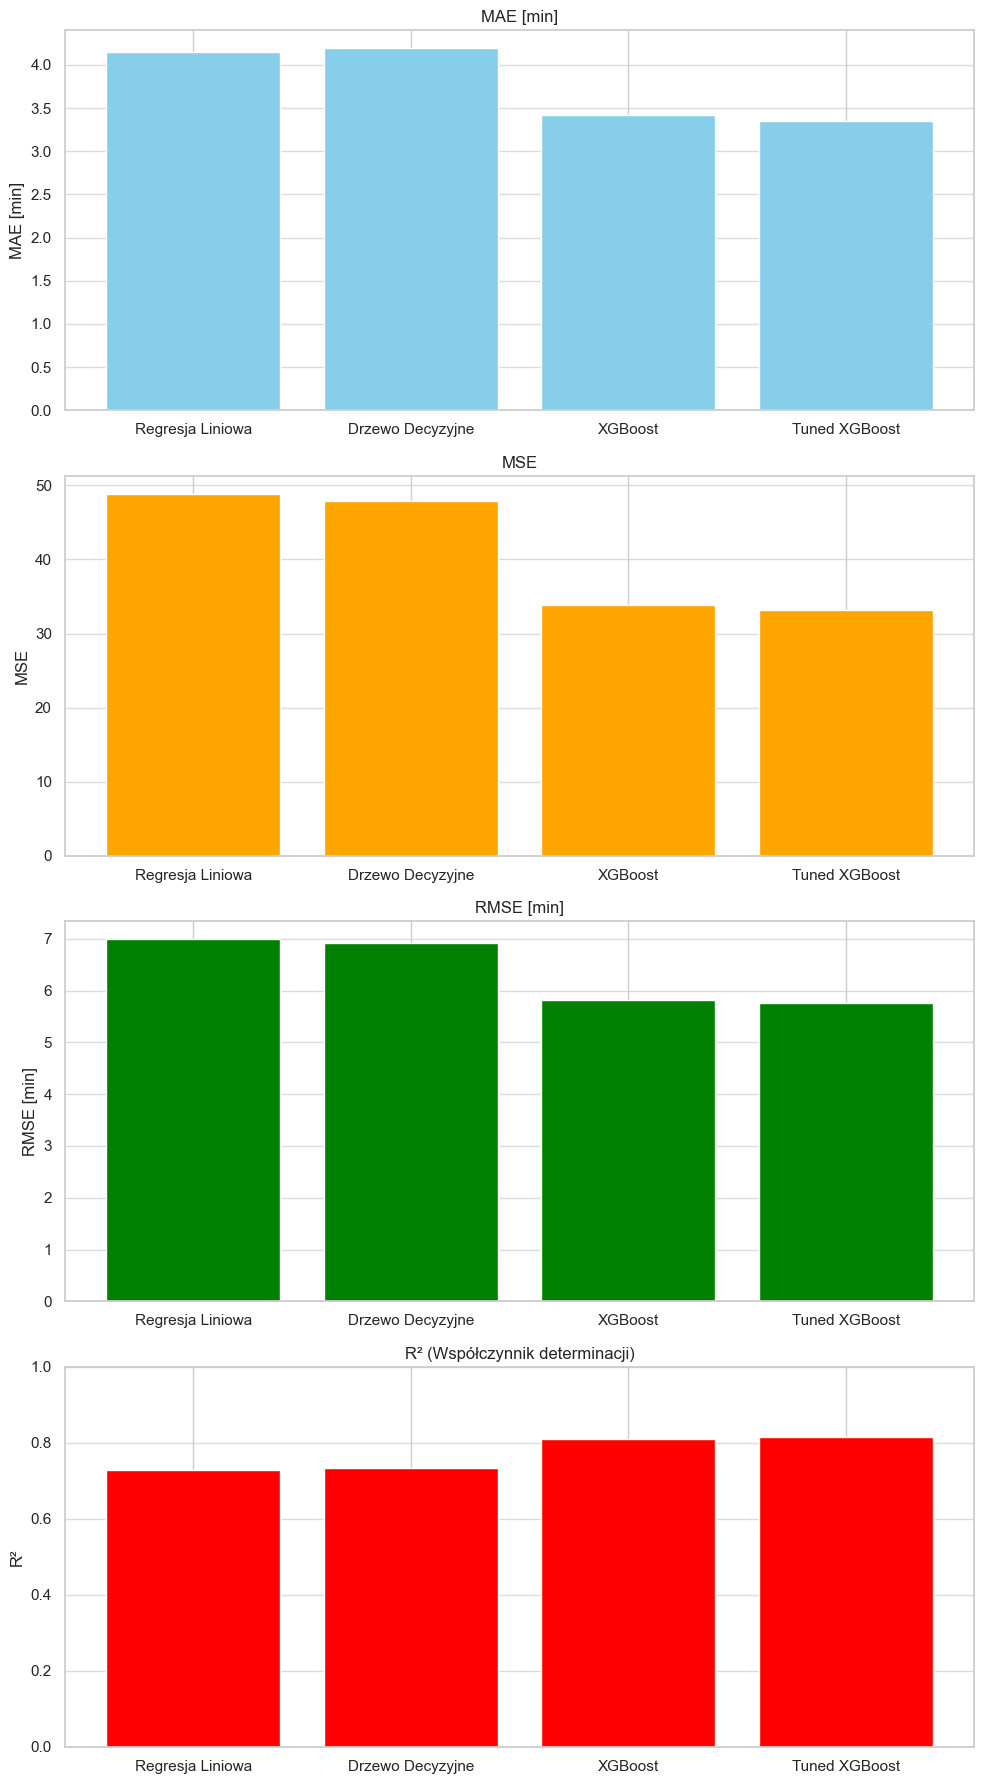

In [148]:
models = df_results['Model']
mae = df_results['MAE']
mse = df_results['MSE']
rmse = df_results['RMSE']
r2 = df_results['R2']

fig, axes = plt.subplots(4, 1, figsize=(10, 18))
axes[0].bar(models, mae, color='skyblue')
axes[0].set_title('MAE [min]')
axes[0].set_ylabel('MAE [min]')
axes[0].grid(axis='y', alpha=0.7)

axes[1].bar(models, mse, color='orange')
axes[1].set_title('MSE')
axes[1].set_ylabel('MSE')
axes[1].grid(axis='y', alpha=0.7)

axes[2].bar(models, rmse, color='green')
axes[2].set_title('RMSE [min]')
axes[2].set_ylabel('RMSE [min]')
axes[2].grid(axis='y', alpha=0.7)

axes[3].bar(models, r2, color='red')
axes[3].set_title('R² (Współczynnik determinacji)')
axes[3].set_ylabel('R²')
axes[3].set_ylim(0, 1)
axes[3].grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

#### Podsumowanie porównania modeli

- **MAE (średni błąd bezwzględny):** Najniższy błąd osiąga XGBoost po tuningu (~3.35 min).
- **MSE/RMSE:** XGBoost i Tuned XGBoost mają wyraźnie niższe błędy kwadratowe, co świadczy o lepszym radzeniu sobie z dużymi odchyleniami.
- **R²:** Najwyższy współczynnik determinacji (0.816) uzyskano dla Tuned XGBoost, co oznacza, że model najlepiej wyjaśnia zmienność czasu przejazdu.

- **Wniosek:** Najlepsze wyniki daje model XGBoost po tuningu – jest najbardziej precyzyjny i najlepiej dopasowany do danych.

In [151]:
joblib.dump(best_xgb, "xgboost_tuned_model.joblib")
print("Model został zapisany")

Model został zapisany


# 9. Predykcja i interpretacja wyników

### Funkcja `predict_trip_duration` – opis działania

Funkcja służy do predykcji czasu przejazdu taksówką na podstawie wybranych cech wejściowych. Wykorzystuje wytrenowany model XGBoost oraz te same przetwarzania cech, co w pipeline modelu.

**Kroki działania:**
- Dystans (`trip_distance`) jest transformowany przez pipeline numeryczny (`num_pipe`).
- Strefy początkowa i końcowa, godzina, dzień tygodnia, miesiąc są kodowane przez pipeline kategoryczny (`cat_pipe`).
- Wszystkie cechy (numeryczne, kategoryczne, binarne flagi) są łączone w jedną macierz wejściową. 
- Model XGBoost przewiduje czas przejazdu w przeskalowanej i przelogarytmowanej postaci.
- Wynik jest przekształcany z powrotem do minut (odwrócenie standaryzacji i logarytmowania).


In [154]:
best_xgb = joblib.load("xgboost_tuned_model.joblib")
def predict_trip_duration(trip_distance,Zone,Zone_DO,hour,weekday,month,
                          is_holiday,is_airport_pickup,is_airport_dropoff,
                          model=best_xgb, num_pipe=num_pipe, cat_pipe=cat_pipe, y_scaler=y_scaler
):
    X_num_ex = num_pipe.transform([[trip_distance]])
    X_cat_ex = cat_pipe.transform([[Zone, Zone_DO, hour, weekday, month]])
    X_rem_ex = np.array([[is_holiday, is_airport_pickup, is_airport_dropoff]], dtype=float)
    X_ex = sparse_hstack([csr_matrix(X_num_ex), X_cat_ex, csr_matrix(X_rem_ex)])

    y_pred_scaled = model.predict(X_ex)
    y_pred_minutes = np.expm1(y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))).flatten()[0]

    print(f"Przewidywany czas przejazdu: {y_pred_minutes:.1f} min")

## 9.1 Ten sam dystans i trasa, różne godziny (szczyt vs noc)

In [160]:
predict_trip_duration(
    trip_distance=4.0,
    Zone="Midtown East",
    Zone_DO="Upper West Side South",
    hour=17,  # szczyt
    weekday=2,
    month=5,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)
predict_trip_duration(
    trip_distance=4.0,
    Zone="Midtown East",
    Zone_DO="Upper West Side South",
    hour=2,    # noc
    weekday=2,
    month=5,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)

Przewidywany czas przejazdu: 33.5 min
Przewidywany czas przejazdu: 15.5 min


- Model prawidłowo uwzględnia wpływ korków w godzinach szczytu na czas przejazdu.


## 9.2 Ten sam dystans i godzina, dzień powszedni vs święto

In [161]:
predict_trip_duration(
    trip_distance=7.0,
    Zone="Midtown East",
    Zone_DO="JFK Airport",
    hour=17,
    weekday=4, # piątek
    month=12,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=1
)
predict_trip_duration(
    trip_distance=7.0,
    Zone="Midtown East",
    Zone_DO="JFK Airport",
    hour=17,
    weekday=4,
    month=12,
    is_holiday=1, # święto
    is_airport_pickup=0,
    is_airport_dropoff=1
)

Przewidywany czas przejazdu: 31.1 min
Przewidywany czas przejazdu: 23.9 min


- Model poprawnie przewiduje, że w święta ruch jest mniejszy, co skraca czas dojazdu na lotnisko.


## 9.3 Krótki dystans w centrum vs na obrzeżach


In [172]:
predict_trip_duration(
    trip_distance=1.5,
    Zone="Midtown East",
    Zone_DO="Midtown West",
    hour=13,
    weekday=3,
    month=7,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)
predict_trip_duration(
    trip_distance=1.5,
    Zone="Queens Village",
    Zone_DO="Jamaica",
    hour=13,
    weekday=3,
    month=7,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)

Przewidywany czas przejazdu: 14.7 min
Przewidywany czas przejazdu: 12.7 min


- Mimo tego samego dystansu, przejazd przez zatłoczone centrum trwa dłużej.


## 9.4 Długi kurs z lotniska vs z dzielnicy

In [165]:
predict_trip_duration(
    trip_distance=10.0,
    Zone="JFK Airport",
    Zone_DO="Midtown East",
    hour=18,
    weekday=5,
    month=9,
    is_holiday=0,
    is_airport_pickup=1,
    is_airport_dropoff=0
)
predict_trip_duration(
    trip_distance=10.0,
    Zone="Astoria",
    Zone_DO="Midtown East",
    hour=18,
    weekday=5,
    month=9,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)

Przewidywany czas przejazdu: 30.5 min
Przewidywany czas przejazdu: 37.2 min


- Model uwzględnia specyfikę ruchu w okolicach lotniska oraz potencjalne korki.

## 9.5 Ten sam dystans i trasa, dzień roboczy vs weekend

In [168]:
predict_trip_duration(
    trip_distance=5.0,
    Zone="Chelsea",
    Zone_DO="Financial District",
    hour=9,
    weekday=2,  # środa
    month=6,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)
predict_trip_duration(
    trip_distance=5.0,
    Zone="Chelsea",
    Zone_DO="Financial District",
    hour=9,
    weekday=6,  # niedziela
    month=6,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)

Przewidywany czas przejazdu: 27.2 min
Przewidywany czas przejazdu: 20.0 min


- W weekendy ruch jest znacznie mniejszy, co przekłada się na krótszy czas przejazdu.

## 9.6 Ten sam dystans i trasa, zima vs lato

In [ ]:
predict_trip_duration(
    trip_distance=8.0,
    Zone="Harlem",
    Zone_DO="Battery Park",
    hour=18,
    weekday=4,
    month=12,  # grudzień (zima)
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)
predict_trip_duration(
    trip_distance=8.0,
    Zone="Harlem",
    Zone_DO="Battery Park",
    hour=18,
    weekday=4,
    month=7,  # lipiec (lato)
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)

Przewidywany czas przejazdu: 30.9 min
Przewidywany czas przejazdu: 27.1 min


- Zima wpływa na wydłużenie czasu przejazdu ze względu na trudniejsze warunki drogowe.

## 9.7 Bardzo krótki kurs w centrum vs na obrzeżach

In [169]:
predict_trip_duration(
    trip_distance=0.5,
    Zone="Times Sq/Theatre District",
    Zone_DO="Midtown East",
    hour=17,
    weekday=1,
    month=3,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)
predict_trip_duration(
    trip_distance=0.5,
    Zone="Springfield Gardens North",
    Zone_DO="Jamaica Bay",
    hour=17,
    weekday=1,
    month=3,
    is_holiday=0,
    is_airport_pickup=0,
    is_airport_dropoff=0
)

Przewidywany czas przejazdu: 7.2 min
Przewidywany czas przejazdu: 4.5 min


- Nawet na bardzo krótkich dystansach obszary o dużym natężeniu ruchu znacząco wydłużają czas przejazdu.

# 10. Podsumowanie ogólne


W ramach zadania przeprowadzono analizę danych taksówek NYC oraz stworzenia modelu przewidującego czas przejazdu.

### 1. Analiza jakości danych

- Dane źródłowe miały względnie dobrą jakość z niewielką liczbą duplikatów.
- Występowały braki danych oraz błędy logiczne, np. zerowe lub ujemne czasy przejazdów.

### 2. Czyszczenie danych

- Usunięto rekordy z nielogicznymi wartościami.
- Wybrano zmienne dostępne w momencie rozpoczęcia podróży.

### 3. Eksploracyjna analiza danych

- Typowe przejazdy trwają 5-30 minut (mediana ~13 min).
- Większość kursów to krótkie trasy 1-5 mil.
- Czas przejazdu jest dłuższy w godzinach szczytu i w dni robocze.
- Kursy na/z lotnisk są znacząco dłuższe.
- Podróże w centrum miasta są wolniejsze niż na obrzeżach.

### 4. Preprocessing

- Transformacja logarytmiczna i standaryzacja zmiennych ciągłych.
- One-hot encoding cech kategorycznych.
- Usunięcie outlierów:
  - czasy > 3h,
  - dystans > 100 mil,
  - skrajne prędkości.

### 5. Porównanie modeli

| Model               | MAE (min) | R²    |
|---------------------|-----------|-------|
| Regresja liniowa    | 4.15      | 0.728 |
| Drzewo decyzyjne    | 4.19      | 0.734 |
| XGBoost             | 3.42      | 0.811 |
| XGBoost po tuningu  | 3.35      | 0.816 |

### 6. Potwierdzone właściwości modelu

- Uwzględnia wpływ korków w godzinach szczytu.
- Rozróżnia dni powszednie i weekendy/święta.
- Bierze pod uwagę specyfikę lokalizacji (centrum vs obrzeża).
- Ujmuje sezonowość (różnice między porami roku).
- Rozpoznaje specyfikę kursów lotniskowych.

### 7. Wnioski biznesowe

- Model zapewnia precyzyjne prognozy czasu przejazdu ze średnim błędem ok. 3.4 minuty.
- Model może być wykorzystany do:
  - Dokładniejszego informowania pasażerów o czasie przejazdu.
  - Optymalizacji przydziału kursów i zarządzania flotą.
  - Planowania czasu pracy kierowców.